# Final Proyect 

In [1]:
from ultralytics import YOLO
import glob
from pathlib import Path

import pandas as pd
import os, cv2, re
import numpy as np
import xml.etree.ElementTree as ET

# Data visualization

Los datos han sido descargados de https://universe.roboflow.com/rjacaac1/ua-detrac-dataset-10k/dataset/2

Estos son archivos txt los cuales estos son los nombres de las columnas en el mismo orden en el que lo encontramos en los archivos

[class_id, center_x, center_y, width, height]

Ahora vamos a visualizar las imagenes que estan en formato jpg. 

- UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/train/images/
- UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/valid/images/

# Data Preprocessing

In [2]:
# Define la ruta raíz donde estás ahora (el punto '.' significa carpeta actual)
# Si ejecutas el script desde fuera, cambia '.' por la ruta completa
dataset_path = './UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8' 

# Listas para almacenar la información
data = []

# Las carpetas que suele tener YOLOv8 (a veces 'test' no existe, por eso lo comprobaremos)
# splits = ['train', 'valid', 'test']
splits = ['train', 'valid'] # NO EXISTE TEST EN NUESTRA DESCARGA 

for split in splits:
    # Construimos la ruta: ./train/images/*.jpg
    search_path = os.path.join(dataset_path, split, 'images', '*.jpg')
    images = glob.glob(search_path)
    
    # Si la carpeta no existe o está vacía (ej. test), pasamos a la siguiente
    if not images:
        continue

    print(f"Procesando {split}: {len(images)} imágenes encontradas.")

    for img_path in images:
        # 1. Obtener ID de la imagen (nombre del archivo sin extensión)
        filename = os.path.basename(img_path)
        image_id = os.path.splitext(filename)[0]
        
        # 2. Construir la ruta de la etiqueta correspondiente
        # La lógica de YOLO es cambiar /images/ por /labels/ y .jpg por .txt
        label_path = img_path.replace('/images/', '/labels/').replace('.jpg', '.txt')
        
        # Opcional: Verificar si el txt existe (para evitar errores luego)
        # if not os.path.exists(label_path):
        #     label_path = None # O marcar como 'missing'
            
        data.append({
            'image_id': image_id,
            'image_path': img_path,   # Ruta de la imagen
            'label_path': label_path, # Ruta del txt
            'set': split            # 'train', 'valid' o 'test'
        })

# Crear el DataFrame
df = pd.DataFrame(data)

# Muestra las primeras filas
print("\n--- Primeras 5 filas del DataFrame ---")
print(df.head())

# Muestra el conteo por set para verificar
print("\n--- Resumen del Dataset ---")
print(df['set'].value_counts())

Procesando train: 9316 imágenes encontradas.
Procesando valid: 500 imágenes encontradas.

--- Primeras 5 filas del DataFrame ---
                                            image_id  \
0  MVI_20052_img00158_jpg.rf.50ed1502ff234681b511...   
1  MVI_39271_img00494_jpg.rf.1184116be16d110fb166...   
2  MVI_39361_img01720_jpg.rf.c1a0eb49147326a4b1bc...   
3  MVI_39401_img00559_jpg.rf.73be5b65ab57747a13c3...   
4  MVI_39771_img00025_jpg.rf.cc566f41b407cf2eb0ba...   

                                          image_path  \
0  ./UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.y...   
1  ./UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.y...   
2  ./UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.y...   
3  ./UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.y...   
4  ./UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.y...   

                                          label_path    set  
0  ./UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.y...  train  
1  ./UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.y...  train  
2  ./UA-DET

In [3]:
df.columns

Index(['image_id', 'image_path', 'label_path', 'set'], dtype='object')

# Training of the model 

## BASELINE

Primero vamos a usar k-fold para el training y validar el modelo ya que tenemos muchas imagenes de train pero no tenemos muchas de validación y las imagenes de train es un video continuo

### K fold stratified

In [4]:
class_names = {0: 'bus', 1: 'car', 2: 'truck', 3: 'van'}

In [5]:
import os
import glob
import yaml
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold

# ==========================================
#        CONFIGURACIÓN
# ==========================================

# 1. RUTA DEL DATASET
# Ajusta esta ruta si es necesario, pero mantén la lógica segura
BASE_PROJECT_DIR = "/home/alumno/Desktop/datos/Computer_vision/final_project"
dataset_path = os.path.join(BASE_PROJECT_DIR, "UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8")

# 2. RUTA DE SALIDA (Exactamente como pediste: carpeta 'folds')
# Se creará en el directorio donde estés ejecutando el script
output_dir = 'folds'
os.makedirs(output_dir, exist_ok=True)

num_folds = 5

# 3. TUS CLASES
class_names = {0: 'bus', 1: 'car', 2: 'truck', 3: 'van'}

# 4. MAPA DE PRIORIDADES
priority_map = {
    0: 0,  # Bus    (Prioridad Máxima)
    2: 1,  # Truck  (Media)
    3: 1,  # Van    (Media)
    1: 2   # Car    (Baja)
}

# ==========================================
#           LÓGICA DEL PROGRAMA
# ==========================================

print(f"--- GENERANDO {num_folds} FOLDS EN '{output_dir}' (MODO SEGURO) ---")

# --- 1. BÚSQUEDA BLINDADA (SOLO TRAIN) ---
# Apuntamos directo a la carpeta train para evitar las de validación
train_imgs_dir = os.path.join(dataset_path, "train/images")
print(f"Buscando imágenes en: {train_imgs_dir}")

# Búsqueda directa
images = glob.glob(os.path.join(train_imgs_dir, '*.jpg'))

# Si están en subcarpetas, buscamos recursivo SOLO dentro de train
if len(images) == 0:
    print("Buscando en subcarpetas de train...")
    images = glob.glob(os.path.join(train_imgs_dir, '**', '*.jpg'), recursive=True)

print(f"Imágenes encontradas: {len(images)}")

# --- VERIFICACIÓN DE SEGURIDAD ---
# Si pasa de 9400, es que se han colado las de Test/Validación.
if len(images) > 9400:
    print("❌ ALERTA: Demasiadas imágenes. Se están colando las de validación.")
    print("El script se detiene por seguridad.")
    exit()
elif len(images) == 0:
    print("❌ ERROR: No se encontraron imágenes.")
    exit()
else:
    print("✅ CORRECTO: Solo estamos usando el set de Entrenamiento.")

# --- 2. ASIGNACIÓN DE PRIORIDADES ---
data = []
print("Calculando prioridades...")

for img_path in images:
    label_path = img_path.replace('/images/', '/labels/').replace('.jpg', '.txt')
    assigned_priority = 99 
    
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
        
        if lines:
            try:
                classes_in_img = set([int(line.split()[0]) for line in lines])
            except:
                classes_in_img = set()
            
            best_prio = 99
            for c in classes_in_img:
                p = priority_map.get(c, 10) 
                if p < best_prio:
                    best_prio = p
            assigned_priority = best_prio
        else:
             assigned_priority = 99
    else:
        assigned_priority = 99

    data.append({
        'path': os.path.abspath(img_path), 
        'priority_group': assigned_priority
    })

df = pd.DataFrame(data)

print("--- Distribución de Prioridades ---")
print(df['priority_group'].value_counts().sort_index())

# --- 3. GENERAR FOLDS EN LA CARPETA 'folds' ---
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

X = df['path']
y = df['priority_group']

print(f"\nGuardando archivos en: {os.path.abspath(output_dir)}")

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    train_files = df.iloc[train_idx]['path'].tolist()
    val_files = df.iloc[val_idx]['path'].tolist()
    
    # Nombres de archivo como tú querías: folds/train_fold_0.txt
    train_txt = os.path.abspath(os.path.join(output_dir, f'train_fold_{fold_idx}.txt'))
    val_txt = os.path.abspath(os.path.join(output_dir, f'val_fold_{fold_idx}.txt'))
    
    with open(train_txt, 'w') as f:
        f.write('\n'.join(train_files))
    with open(val_txt, 'w') as f:
        f.write('\n'.join(val_files))
        
    yaml_content = {
        'path': dataset_path, 
        'train': train_txt,
        'val': val_txt,
        'names': class_names
    }
    
    yaml_filename = os.path.join(output_dir, f'fold_{fold_idx}.yaml')
    with open(yaml_filename, 'w') as f:
        yaml.dump(yaml_content, f, sort_keys=False)

print(f"\n✅ ¡Listo! Folds generados en la carpeta '{output_dir}'.")

--- GENERANDO 5 FOLDS EN 'folds' (MODO SEGURO) ---
Buscando imágenes en: /home/alumno/Desktop/datos/Computer_vision/final_project/UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/train/images
Imágenes encontradas: 9316
✅ CORRECTO: Solo estamos usando el set de Entrenamiento.
Calculando prioridades...
--- Distribución de Prioridades ---
priority_group
0    1350
1    5063
2    2903
Name: count, dtype: int64

Guardando archivos en: /home/alumno/Desktop/datos/Computer_vision/final_project/folds

✅ ¡Listo! Folds generados en la carpeta 'folds'.


En la siguiente celda vamos a realizar el k-fold stratified. Se utiliza el modelo ya pre-entrenado de yolov8.

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- TUS DATOS OBTENIDOS ---
data = {
    'Grupo': ['Grupo 0\n(Bus Class)', 'Grupo 1\n(Truck/Van)', 'Grupo 2\n(Only Cars)'],
    'Cantidad': [1350, 5063, 2903],
    'Prioridad': ['Alta', 'Media', 'Baja']
}

df = pd.DataFrame(data)

# Calcular porcentajes
total = df['Cantidad'].sum()
df['Porcentaje'] = (df['Cantidad'] / total) * 100

# --- GRÁFICO ---
plt.figure(figsize=(10, 6))
colors = ['#ff4444', '#ffbb33', '#00C851'] # Rojo, Naranja, Verde

ax = sns.barplot(data=df, x='Grupo', y='Cantidad', hue='Grupo', palette=colors, legend=False)

# Añadir etiquetas de valor y porcentaje
for i, p in enumerate(ax.patches):
    height = p.get_height()
    percentage = df.iloc[i]['Porcentaje']
    ax.text(p.get_x() + p.get_width() / 2., height + 50,
            f'{int(height)}\n({percentage:.1f}%)',
            ha="center", fontsize=12, fontweight='bold')

plt.title(f"Priority-based Image Distribution for K-Fold\n(Total: {total} images)", fontsize=14)
plt.ylabel("Number of images")
plt.xlabel("Classification category")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(0, 6000) # Un poco de margen arriba

# Guardar
plt.savefig("distribucion_prioridades_kfold.png")
print("✅ Gráfico guardado como 'distribucion_prioridades_kfold.png'")
plt.show()

✅ Gráfico guardado como 'distribucion_prioridades_kfold.png'


<Figure size 1000x600 with 1 Axes>

In [6]:
from ultralytics import YOLO
import numpy as np
import torch

# --- CONFIGURACIÓN ---
num_folds = 5
epochs = 10
batch_size = 16
img_size = 640
model_name = 'yolov8n.pt' 

# Listas para guardar resultados
map50_results = []
map50_95_results = []

print(f"--- INICIANDO CROSS-VALIDATION K={num_folds} (Deterministic) ---")

for k in range(num_folds):
    print(f"\nTraining Fold {k+1}/{num_folds}...")
    
    # Cargar modelo limpio
    model = YOLO(model_name)
    
    results = model.train(
        data=f'folds/fold_{k}.yaml', 
        epochs=epochs,
        imgsz=img_size,
        batch=batch_size,
        project='runs/kfold',
        name=f'fold_{k}',
        patience=10,
        verbose=True,
        exist_ok=True,
        
        # --- AJUSTES DE REPRODUCIBILIDAD ---
        seed=42,             
        deterministic=True,  # Fuerza operaciones deterministas en CUDA (un poco más lento, pero exacto)
        workers=4            # Número de hilos para cargar datos
    )
    
    # Validación
    metrics = model.val()
    
    map50_results.append(metrics.box.map50)
    map50_95_results.append(metrics.box.map)

# --- INFORME FINAL ---
print("\n" + "="*40)
print(f"RESUMEN K-FOLD (Avg over {num_folds} folds)")
print("="*40)
for i in range(num_folds):
    print(f"Fold {i}: mAP@50 = {map50_results[i]:.4f} | mAP@50-95 = {map50_95_results[i]:.4f}")

print("-" * 40)
print(f"Promedio mAP@50:    {np.mean(map50_results):.4f}")
print(f"Promedio mAP@50-95: {np.mean(map50_95_results):.4f}")
print("="*40)

--- INICIANDO CROSS-VALIDATION K=5 (Deterministic) ---

Training Fold 1/5...
New https://pypi.org/project/ultralytics/8.4.4 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.247 🚀 Python-3.13.7 torch-2.9.1+cu128 CUDA:0 (NVIDIA RTX PRO 6000 Blackwell Max-Q Workstation Edition, 97248MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=folds/fold_0.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=trai

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ajusta esto si cambiaste la carpeta 'runs/kfold' en tu código
project_path = 'runs/kfold' 
num_folds = 5

results_summary = []

plt.figure(figsize=(20, 6))
print(f"--- RECUPERANDO RESULTADOS DE {project_path} ---")

for k in range(num_folds):
    fold_dir = os.path.join(project_path, f'fold_{k}')
    
    # 1. Recuperar Métricas del archivo results.csv
    # YOLO guarda un historial epoch a epoch. Leemos la última fila (o la mejor).
    csv_file = os.path.join(fold_dir, 'results.csv')
    
    if os.path.exists(csv_file):
        df = pd.read_csv(csv_file)
        # Limpiamos espacios en los nombres de columnas
        df.columns = df.columns.str.strip()
        
        # Buscamos la fila donde 'metrics/mAP50(B)' es máximo
        best_epoch = df.loc[df['metrics/mAP50(B)'].idxmax()]

        #Aquí se coge las metricas con (B) porque yolo indica que estas métricas son de la box
        results_summary.append({
            'Fold': k,
            'Precision': best_epoch['metrics/precision(B)'],
            'Recall': best_epoch['metrics/recall(B)'],
            'mAP@50': best_epoch['metrics/mAP50(B)'],
            'mAP@50-95': best_epoch['metrics/mAP50-95(B)']
        })
    else:
        print(f"Advertencia: No se encontró results.csv para el Fold {k}")

    # 2. Visualizar Matriz de Confusión
    # Buscamos la normalizada primero, si no la simple
    matrix_path = os.path.join(fold_dir, 'confusion_matrix_normalized.png')
    if not os.path.exists(matrix_path):
        matrix_path = os.path.join(fold_dir, 'confusion_matrix.png')
        
    plt.subplot(1, 5, k+1)
    if os.path.exists(matrix_path):
        img = plt.imread(matrix_path)
        plt.imshow(img)
        plt.title(f"Fold {k}")
        plt.axis('off')
    else:
        plt.text(0.5, 0.5, "No Matriz", ha='center')
        plt.axis('off')

plt.tight_layout()
plt.show()

# 3. Mostrar Tabla de Resultados
print("\n" + "="*50)
print("RESUMEN FINAL (Extraído de results.csv)")
print("="*50)
if results_summary:
    df_res = pd.DataFrame(results_summary)
    df_res.set_index('Fold', inplace=True)
    
    # Añadir promedio
    df_res.loc['PROMEDIO'] = df_res.mean()
    
    print(df_res.round(4))
else:
    print("No se encontraron resultados para mostrar.")
print("="*50)

--- RECUPERANDO RESULTADOS DE runs/kfold ---


<Figure size 2000x600 with 5 Axes>


RESUMEN FINAL (Extraído de results.csv)
          Precision  Recall  mAP@50  mAP@50-95
Fold                                          
0            0.9392  0.9187  0.9677     0.8273
1            0.9278  0.9255  0.9610     0.8146
2            0.9356  0.9083  0.9624     0.8231
3            0.9364  0.9168  0.9654     0.8187
4            0.9179  0.9263  0.9626     0.8189
PROMEDIO     0.9314  0.9191  0.9638     0.8205


In [7]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import os
import glob

# Configuración
num_folds = 5
project_path = 'runs/kfold' 

# Lista para guardar las rutas de las nuevas matrices
matrix_paths = []

print(f"--- GENERANDO MATRICES FALTANTES DESDE {project_path} ---")

for k in range(num_folds):
    # 1. Buscamos los pesos del modelo que ya entrenaste
    weights_path = os.path.join(project_path, f'fold_{k}', 'weights', 'best.pt')
    
    if os.path.exists(weights_path):
        print(f"\nProcessing Fold {k} (Generando gráficos)...")
        
        # Cargar el modelo ya entrenado
        model = YOLO(weights_path)
        
        # 2. Ejecutar validación explícita para crear los gráficos
        # Guardaremos esto en una carpeta nueva 'fold_X_val' para no mezclar
        model.val(
            data=f'folds/fold_{k}.yaml',
            project=project_path,
            name=f'fold_{k}_val', # Carpeta nueva: runs/kfold/fold_0_val
            plots=True,           # FUERZA la creación de matrices
            exist_ok=True,         # Sobrescribe si ya lo intentaste
            verbose=False
        )
        
        # Guardamos la ruta donde debería haber aparecido la matriz
        # YOLOv8 a veces la llama 'confusion_matrix_normalized.png' o sin normalizar
        path_norm = os.path.join(project_path, f'fold_{k}_val', 'confusion_matrix_normalized.png')
        path_raw = os.path.join(project_path, f'fold_{k}_val', 'confusion_matrix.png')
        
        if os.path.exists(path_norm):
            matrix_paths.append(path_norm)
        elif os.path.exists(path_raw):
            matrix_paths.append(path_raw)
        else:
            matrix_paths.append(None)
            
    else:
        print(f"Error: No se encontraron pesos para el Fold {k} en {weights_path}")
        matrix_paths.append(None)

# --- VISUALIZAR LAS MATRICES ---
print("\n" + "="*50)
print("MATRICES DE CONFUSIÓN GENERADAS")
print("="*50)

plt.figure(figsize=(20, 5))

for k, img_path in enumerate(matrix_paths):
    plt.subplot(1, 5, k+1)
    if img_path and os.path.exists(img_path):
        img = plt.imread(img_path)
        plt.imshow(img)
        plt.title(f"Fold {k}")
        plt.axis('off')
    else:
        plt.text(0.5, 0.5, "No Image Found", ha='center')
        plt.title(f"Fold {k} (Error)")
        plt.axis('off')

plt.tight_layout()
plt.show()

--- GENERANDO MATRICES FALTANTES DESDE runs/kfold ---

Processing Fold 0 (Generando gráficos)...
Ultralytics 8.3.247 🚀 Python-3.13.7 torch-2.9.1+cu128 CUDA:0 (NVIDIA RTX PRO 6000 Blackwell Max-Q Workstation Edition, 97248MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 424.6±471.5 MB/s, size: 56.6 KB)
val: Scanning /home/alumno/Desktop/datos/Computer_vision/final_project/UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/train/labels... 1864 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1864/1864 2.0Kit/s 0.9s0.0s
val: New cache created: /home/alumno/Desktop/datos/Computer_vision/final_project/UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/train/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 117/117 13.3it/s 8.8s0.1s
                   all       1864      17172      0.939      0.919      0.968      0.828
Speed: 0.8ms pre

<Figure size 2000x500 with 5 Axes>

#### Matriz de confusión global

In [10]:
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- CONFIGURACIÓN ---
num_folds = 5
project_path = 'runs/kfold'
class_names = {0: 'bus', 1: 'car', 2: 'truck', 3: 'van'} 
# formato_columnas--> Sirve para hacer que las columnas de la matriz de normalización sumen 1 (Mismo formato que sckitic-learn)
formato_columnas = True
save_matrix = True
path_matrix = "./normalized matrix k-fold.png"
total_matrix = None 

print(f"--- CALCULANDO MATRIZ DE CONFUSIÓN GLOBAL (K={num_folds}) ---")
print(f"Buscando modelos en: {project_path}")

for k in range(num_folds):
    print(f"\n>>> Procesando Fold {k}...")
    
    # 1. Verificar que el archivo de pesos existe
    weights_path = os.path.join(project_path, f'fold_{k}', 'weights', 'best.pt')
    
    if not os.path.exists(weights_path):
        print(f"❌ ERROR: No se encuentra el archivo: {weights_path}")
        print("   ¿Seguro que el entrenamiento terminó y guardó los pesos?")
        continue # Saltamos este fold si no hay modelo
        
    model = YOLO(weights_path)
    
    # 2. Validar CON plots=True para forzar el cálculo de la matriz
    print(f"   Validando con: folds/fold_{k}.yaml")
    metrics = model.val(
        data=f'folds/fold_{k}.yaml', 
        plots=True,    
        verbose=False
    )
    
    # Check de seguridad: ¿El modelo está detectando algo?
    print(f"   mAP50-95 obtenido: {metrics.box.map:.4f}")
    
    if metrics.box.map == 0:
        print("   ⚠️ CUIDADO: El mAP es 0. El modelo no detecta nada o no encuentra etiquetas.")
    
    # 3. Extraer la matriz
    current_matrix = metrics.confusion_matrix.matrix
    
    # 4. Sumar
    if total_matrix is None:
        total_matrix = current_matrix
    else:
        if total_matrix.shape == current_matrix.shape:
            total_matrix += current_matrix
        else:
            print(f"⚠️ Error de dimensiones en Fold {k}. Saltando.")

# --- VISUALIZACIÓN ---
if total_matrix is not None and total_matrix.sum() > 0:
    print("\nGenerando Gráfico Global...")
    
    # Etiquetas + Background
    labels = list(class_names.values()) + ['background']
    
    # Normalización segura
    row_sums = total_matrix.sum(axis=1, keepdims=True)
    # Evitar división por cero donde no hay datos
    row_sums[row_sums == 0] = 1 
    norm_matrix = total_matrix / row_sums

    #Transponemos la matriz normalizada para que nos salgan que la suma de las columnas es igual a 1
    norm_matrix_transpuesta = norm_matrix.T
    
    if formato_columnas: 
        plt.figure(figsize=(10, 8))
        sns.heatmap(norm_matrix_transpuesta, 
                    annot=True, 
                    fmt='.2f', 
                    cmap='Blues',
                    xticklabels=labels, 
                    yticklabels=labels)
    
        plt.title(f'Matriz de Confusión Global (K-Fold Acumulado)\nTotal Muestras: {int(total_matrix.sum())}')
        plt.xlabel('PREDICTIONS')
        plt.ylabel('TRUTH VALUES')
        if save_matrix and path_matrix != None :
            print(f"Se ha guardado la matriz normalizada transpuesta en:\n{path_matrix}")
            plt.savefig(path_matrix,dpi = 300)
        plt.show()
    else:
        plt.figure(figsize=(10, 8))
        sns.heatmap(norm_matrix,
                    annot=True, 
                    fmt='.2f', 
                    cmap='Blues',
                    xticklabels=labels, 
                    yticklabels=labels)
    
        plt.title(f'Matriz de Confusión Global (K-Fold Acumulado)\nTotal Muestras: {int(total_matrix.sum())}')
        plt.xlabel('TRUTH VALUES')
        plt.ylabel('PREDICTIONS')
        if save_matrix and path_matrix != None :
            print(f"Se ha guardado la matriz normalizada en:\n {path_matrix}")
            plt.savefig(path_matrix,dpi = 300)
        plt.show()
    print("\n--- Conteos Absolutos Totales ---")
    print(total_matrix)
else:
    print("\n❌ ERROR FINAL: La matriz total es 0 o vacía.")
    print("Revisa que los archivos .txt de las etiquetas estén en la ruta correcta definida en los YAML.")

--- CALCULANDO MATRIZ DE CONFUSIÓN GLOBAL (K=5) ---
Buscando modelos en: runs/kfold

>>> Procesando Fold 0...
   Validando con: folds/fold_0.yaml
Ultralytics 8.3.247 🚀 Python-3.13.7 torch-2.9.1+cu128 CUDA:0 (NVIDIA RTX PRO 6000 Blackwell Max-Q Workstation Edition, 97248MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.1±0.1 ms, read: 439.6±260.1 MB/s, size: 61.1 KB)
val: Scanning /home/alumno/Desktop/datos/Computer_vision/final_project/UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/train/labels... 1864 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1864/1864 2.0Kit/s 0.9s0.0s
val: New cache created: /home/alumno/Desktop/datos/Computer_vision/final_project/UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/train/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 117/117 11.4it/s 10.3s0.1s
                   all       1864      17172      0.939

<Figure size 1000x800 with 2 Axes>


--- Conteos Absolutos Totales ---
[[       1324           4          12          11         169]
 [         23       67629         786          16        9646]
 [         36         505        5697          23        1608]
 [         16          25          18        6992         558]
 [         39        2330         156         101           0]]


Los resultados obtenidos son muy buenos ya que vemos que los valores principales estan en la diagonal principal, con un 74 % el menor valor de las 4 clases. El background da valores altos en todas las clases debido a que muchos de estos ejemplos son debidos a que no estan etiquetados los vehículos. Sin embargo, los modelos utilizados consiguen detectarlos. Por lo tanto, no nos vamos a preocupar por estos ejemplos. Si no tenemos en cuenta el background la clase que más se confunde son los truck ( Que contiene a camiones y camionetas)

# Inicio Phase 2 Model with Advanced Data Augmentation (GRID DISTORTION AND ELASTIC DISTORTION)

Hay que instalar la libreria albumentations. Esta libreria la utiliza YOLO para poder aplicar data augmentation

In [11]:
# EJECUTA ESTO Y LUEGO REINICIA EL KERNEL
# !uv pip uninstall albumentations
# !uv pip install albumentations==1.3.1

Using Python 3.13.7 environment at: /home/alumno/py313ml/.venv
Uninstalled 1 package in 4ms
 - albumentations==1.3.1
Using Python 3.13.7 environment at: /home/alumno/py313ml/.venv
Resolved 17 packages in 129ms                                        
Installed 1 package in 1ms.1                                
 + albumentations==1.3.1


In [11]:
import albumentations
print(f"Versión de Albumentations cargada: {albumentations.__version__}")
# Debe imprimir: 1.3.1

Versión de Albumentations cargada: 2.0.8


In [12]:
import ultralytics
print(ultralytics.__version__)

8.3.247


In [3]:
# !uv pip install -U ultralytics albumentations

Using Python 3.13.7 environment at: /home/alumno/py313ml/.venv
Resolved 60 packages in 675ms                                        
Prepared 28 packages in 2.21s                                            
Uninstalled 27 packages in 778ms
Installed 28 packages in 625ms                              
 - albumentations==1.3.1
 + albumentations==2.0.8
 - certifi==2025.8.3
 + certifi==2026.1.4
 - charset-normalizer==3.4.3
 + charset-normalizer==3.4.4
 - filelock==3.19.1
 + filelock==3.20.2
 - fonttools==4.60.0
 + fonttools==4.61.1
 - fsspec==2025.9.0
 + fsspec==2025.12.0
 - idna==3.7
 + idna==3.11
 - markupsafe==3.0.2
 + markupsafe==3.0.3
 - matplotlib==3.10.6
 + matplotlib==3.10.8
 - networkx==3.5
 + networkx==3.6.1
 - numpy==2.3.3
 + numpy==2.4.0
 - nvidia-nccl-cu12==2.27.3
 + nvidia-nccl-cu12==2.27.5
 + nvidia-nvshmem-cu12==3.3.20
 - opencv-python-headless==4.10.0.84
 + opencv-python-headless==4.11.0.86
 - pillow==11.3.0
 + pillow==12.1.0
 - psutil==7.1.0
 + psutil==7.2.1
 - pydantic==2

## Training Model

In [18]:
import os
import pandas as pd
import albumentations as A
from ultralytics import YOLO

# 1. Definimos las transformaciones
custom_transforms = [
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, p=0.5),
    A.GaussNoise(p=0.3),
]

# Configuración
num_folds = 5  
epochs = 10
img_size = 640
batch_size = 16
model_name = "yolov8n.pt"
project_name = 'runs/kfold_distorted'

# <--- AÑADIDO: Faltaba inicializar la lista para guardar resultados
results_summary = [] 

# 2. Bucle de entrenamiento
for k in range(num_folds):
    yaml_file = f'folds/fold_{k}.yaml'
    if not os.path.exists(yaml_file): 
        continue

    print(f"\nTraining Fold {k+1} con distorsiones geométricas...")
    
    # <--- AÑADIDO: Definimos run_name aquí para usarlo en el train y en el path
    run_name = f'fold_{k}' 

    # Cargar modelo
    model = YOLO(model_name)
    
    model.train(
        data=yaml_file,
        epochs=epochs,
        imgsz=img_size,
        batch=batch_size,
        project=project_name,
        name=run_name,        # <--- AHORA USAMOS LA VARIABLE
        patience=10, 
        verbose=True,
        exist_ok=True,
        augmentations=custom_transforms, 
        seed=42,
        deterministic=True,
        workers=4,
        degrees=0.0,
        mosaic=0.0,     
        mixup=0.0,       
        copy_paste=0.0   
    )

    # Construir ruta al CSV
    # Ahora 'run_name' ya existe, así que esto funcionará
    results_path = os.path.join(project_name, run_name, 'results.csv')
    
    if os.path.exists(results_path):
        # Leemos el CSV generado por YOLO
        df = pd.read_csv(results_path)
        df.columns = df.columns.str.strip()
        
        # Buscamos la mejor fila
        best_idx = df['metrics/mAP50(B)'].idxmax()
        best_epoch_data = df.iloc[best_idx]
        
        # Guardamos
        results_summary.append({
            'Fold': k,
            'Precision': best_epoch_data['metrics/precision(B)'],
            'Recall': best_epoch_data['metrics/recall(B)'],
            'mAP@50': best_epoch_data['metrics/mAP50(B)'],
            'mAP@50-95': best_epoch_data['metrics/mAP50-95(B)']
        })
        
        print(f"-> Fold {k}: Mejor época encontrada (Ep {int(best_epoch_data['epoch'])}) con mAP@50: {best_epoch_data['metrics/mAP50(B)']:.4f}")
    else:
        print(f"Error: No se encontró el archivo de resultados en {results_path}")

# --- 3. PROCESAMIENTO FINAL Y GUARDADO ---

if results_summary: # Verificación extra por si la lista está vacía
    df_final = pd.DataFrame(results_summary)
    df_final.set_index('Fold', inplace=True)

    # Calculamos el promedio
    df_final.loc['PROMEDIO'] = df_final.mean()

    # Mostramos en consola
    print("\n" + "="*50)
    print(df_final)
    print("="*50)

    # Guardamos a CSV
    output_csv_name = 'kfold_final_results.csv'
    df_final.to_csv(output_csv_name)
    print(f"Resultados guardados exitosamente en '{output_csv_name}'")
else:
    print("No se generaron resultados para guardar.")


Training Fold 1 con distorsiones geométricas...
New https://pypi.org/project/ultralytics/8.4.4 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.247 🚀 Python-3.13.7 torch-2.9.1+cu128 CUDA:0 (NVIDIA RTX PRO 6000 Blackwell Max-Q Workstation Edition, 97248MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, augmentations=[GridDistortion(p=0.5, border_mode=0, distort_limit=(-0.3, 0.3), fill=0.0, fill_mask=0.0, interpolation=1, keypoint_remapping_method='mask', mask_interpolation=0, normalized=True, num_steps=5), ElasticTransform(p=0.5, alpha=1.0, approximate=False, border_mode=0, fill=0.0, fill_mask=0.0, interpolation=1, keypoint_remapping_method='mask', mask_interpolation=0, noise_distribution='gaussian', same_dxdy=False, sigma=50.0), GaussNoise(p=0.3, mean_range=(0.0, 0.0), noise_scale_factor=1.0, per_channel=True, std_range=(0.2, 0.44))], auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, 

In [19]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ultralytics import YOLO

# --- CONFIGURACIÓN (Debe coincidir con tu entrenamiento anterior) ---
num_folds = 5
project_name = 'runs/kfold_distorted'  # <--- Ruta donde se guardaron los entrenamientos
class_names = {0: 'bus', 1: 'car', 2: 'truck', 3: 'van'} # Ajusta esto a tus clases reales

# Configuración del gráfico
formato_columnas = True # True = Transponer matriz (Columnas suman 1)
save_matrix = True
path_matrix = "./normalized_matrix_kfold_final.png"

# Variable para acumular
total_matrix = None 

print(f"--- GENERANDO MATRIZ ACUMULADA DE {num_folds} FOLDS ---")
print(f"Leyendo modelos desde: {project_name}")

# --- BUCLE DE LECTURA Y ACUMULACIÓN ---
for k in range(num_folds):
    print(f"\n>>> Procesando Fold {k}...")
    
    # 1. Construimos la ruta al mejor peso de ese fold
    weights_path = os.path.join(project_name, f'fold_{k}', 'weights', 'best.pt')
    yaml_file = f'folds/fold_{k}.yaml' # Necesitamos el YAML para validar
    
    # Verificamos que existan
    if not os.path.exists(weights_path):
        print(f"❌ ERROR: No se encuentra el modelo: {weights_path}")
        continue 
        
    if not os.path.exists(yaml_file):
        print(f"❌ ERROR: No se encuentra el YAML: {yaml_file}")
        continue

    # 2. Cargamos el modelo ya entrenado
    model = YOLO(weights_path)
    
    # 3. Validamos (plots=True es necesario para que calcule la matriz interna)
    # verbose=False para que no llene la pantalla de texto
    metrics = model.val(data=yaml_file, plots=True, verbose=False)
    
    # 4. Extraemos la matriz de confusión
    # La matriz viene como objeto, accedemos a sus datos numéricos con .matrix
    current_matrix = metrics.confusion_matrix.matrix
    
    # 5. Acumulamos (Sumamos la matriz actual a la total)
    if total_matrix is None:
        total_matrix = current_matrix
    else:
        # Verificamos dimensiones por seguridad
        if total_matrix.shape == current_matrix.shape:
            total_matrix += current_matrix
        else:
            print(f"⚠️ Error de dimensiones en Fold {k}. Se omite.")

# --- VISUALIZACIÓN Y GUARDADO ---
if total_matrix is not None and total_matrix.sum() > 0:
    print("\nGenerando Gráfico Global...")
    
    # Definir etiquetas (Clases + Background que añade YOLO)
    labels = list(class_names.values())
    
    # Ajuste de etiquetas si YOLO detectó 'background' o menos clases
    if total_matrix.shape[0] > len(labels):
        labels.append('background')
    elif total_matrix.shape[0] < len(labels):
        # Si el modelo nunca predijo una clase, la matriz es más pequeña
        labels = labels[:total_matrix.shape[0]]

    # 1. Normalización por filas (Recall)
    row_sums = total_matrix.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1 # Evitar división por cero
    norm_matrix = total_matrix / row_sums

    # 2. Configuración del plot según tu preferencia
    plt.figure(figsize=(10, 8))
    
    if formato_columnas:
        # Transponemos para que visualmente las columnas sumen 1
        data_to_plot = norm_matrix.T
        x_label = 'PREDICTIONS'
        y_label = 'TRUTH VALUES'
        title_suffix = "(Transpuesta - Columnas suman 1)"
    else:
        # Normal (Filas suman 1)
        data_to_plot = norm_matrix
        x_label = 'TRUTH VALUES' # YOLO pone Truth en X por defecto en su matriz interna
        y_label = 'PREDICTIONS'
        title_suffix = "(Filas suman 1)"

    # 3. Dibujar Heatmap
    sns.heatmap(data_to_plot, 
                annot=True, 
                fmt='.2f', 
                cmap='Blues',
                xticklabels=labels, 
                yticklabels=labels)
    
    plt.title(f'Matriz de Confusión Global (K-Fold Acumulado)\n{title_suffix}\nTotal Muestras: {int(total_matrix.sum())}')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    # 4. Guardar
    if save_matrix:
        plt.savefig(path_matrix, dpi=300)
        print(f"✅ Matriz guardada en: {path_matrix}")
    
    plt.show()

    print("\n--- Conteos Absolutos Totales ---")
    print(total_matrix)

else:
    print("\n❌ No se pudo generar la matriz. Revisa las rutas.")

--- GENERANDO MATRIZ ACUMULADA DE 5 FOLDS ---
Leyendo modelos desde: runs/kfold_distorted

>>> Procesando Fold 0...
Ultralytics 8.3.247 🚀 Python-3.13.7 torch-2.9.1+cu128 CUDA:0 (NVIDIA RTX PRO 6000 Blackwell Max-Q Workstation Edition, 97248MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.1±0.0 ms, read: 495.0±477.8 MB/s, size: 57.4 KB)
val: Scanning /home/alumno/Desktop/datos/Computer_vision/final_project/UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/train/labels... 1864 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1864/1864 2.6Kit/s 0.7s0.0s
val: New cache created: /home/alumno/Desktop/datos/Computer_vision/final_project/UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/train/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 117/117 15.3it/s 7.6s0.1s
                   all       1864      17172      0.935      0.903      0.959      0.8

/tmp/ipykernel_2098/3395107394.py:113: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


## Ver peores imagenes distorsion

In [20]:
import os
import cv2
import glob
import matplotlib.pyplot as plt
from ultralytics import YOLO
from tqdm import tqdm
from pathlib import Path

# --- CONFIGURACIÓN ---
folds_dir = './folds'             # Donde están los txt (val_fold_0.txt...)
project_name = 'runs/kfold_distorted' 
base_output_name = 'prueba'       # Nombre base para la carpeta (creará prueba1, prueba2...)
num_folds = 5
iou_threshold = 0.45 
top_n_worst = 10                  # Cuántas imágenes guardar

# --- CLASES ---
CLASS_NAMES = {
    0: 'bus',
    1: 'car',
    2: 'truck',
    3: 'van'
}

# --- 1. LÓGICA DE CARPETAS INCREMENTALES (CHECKPOINTS) ---
def get_next_folder(base_name):
    """
    Busca la siguiente carpeta libre: prueba1, prueba2, prueba3...
    """
    i = 1
    while True:
        folder_name = f"{base_name}{i}"
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)
            return folder_name
        i += 1

# Creamos la nueva carpeta automáticamente
save_dir = get_next_folder(base_output_name)
print(f"--> Los resultados se guardarán en la carpeta: {save_dir}/")

# --- FUNCIONES AUXILIARES ---
def get_class_name(cls_id):
    return CLASS_NAMES.get(int(cls_id), str(int(cls_id)))

def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    return interArea / float(boxAArea + boxBArea - interArea + 1e-6)

def analyze_image(model, img_path, fold_idx):
    img = cv2.imread(img_path)
    if img is None: return None
    h, w, _ = img.shape

    # 1. Ground Truth
    label_path = img_path.replace('/images/', '/labels/').replace('.jpg', '.txt').replace('.png', '.txt')
    gt_boxes = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = list(map(float, line.strip().split()))
                if len(parts) >= 5:
                    c, x, y, bw, bh = parts[:5]
                    l, t, r, b = int((x - bw/2) * w), int((y - bh/2) * h), int((x + bw/2) * w), int((y + bh/2) * h)
                    gt_boxes.append([l, t, r, b, int(c)])

    # 2. Predicciones
    results = model(img, conf=0.25, verbose=False)
    pred_boxes = []
    for r in results:
        for box in r.boxes:
            b_c = box.xyxy[0].cpu().numpy().astype(int)
            pred_boxes.append([b_c[0], b_c[1], b_c[2], b_c[3], int(box.cls), float(box.conf)])

    # 3. Calcular Error
    missed = 0
    gt_matched = [False] * len(gt_boxes)
    pred_matched = [False] * len(pred_boxes)

    for i, gt in enumerate(gt_boxes):
        best_iou = 0
        best_pred_idx = -1
        for j, pred in enumerate(pred_boxes):
            if pred_matched[j]: continue
            iou = calculate_iou(gt[:4], pred[:4])
            if iou > best_iou:
                best_iou = iou
                best_pred_idx = j
        
        if best_iou >= iou_threshold:
            gt_matched[i] = True
            pred_matched[best_pred_idx] = True
        else:
            missed += 1

    false_positives = pred_matched.count(False)
    error_score = missed + false_positives

    return {
        'path': img_path,
        'fold': fold_idx,
        'score': error_score,
        'gt': gt_boxes,
        'pred': pred_boxes,
        'img': img 
    }

# --- PROCESO PRINCIPAL ---
analyzed_images = []

for k in range(num_folds):
    txt_file = os.path.join(folds_dir, f'val_fold_{k}.txt')
    if not os.path.exists(txt_file): 
        print(f"No existe {txt_file}, saltando...")
        continue

    with open(txt_file, 'r') as f:
        img_paths = [line.strip() for line in f.readlines()]
    
    # IMPORTANTE: Ajusta este slice si quieres procesar más o menos imágenes
    paths_to_check = img_paths[:50] 

    model_path = os.path.join(project_name, f'fold_{k}', 'weights', 'best.pt')
    if not os.path.exists(model_path): 
        print(f"Modelo fold {k} no encontrado.")
        continue
    
    model = YOLO(model_path)

    for p in tqdm(paths_to_check, desc=f"Procesando Fold {k}"):
        if not os.path.exists(p): continue
        result = analyze_image(model, p, k)
        # Guardamos si tiene algún error (score > 0)
        if result and result['score'] > 0: 
            analyzed_images.append(result)

# --- GUARDADO Y VISUALIZACIÓN ---

# Ordenar por error (De más errores a menos)
analyzed_images.sort(key=lambda x: x['score'], reverse=True)

print(f"\nGuardando las {top_n_worst} peores imágenes en '{save_dir}'...")

for i, item in enumerate(analyzed_images[:top_n_worst]):
    img = item['img'].copy()
    gt = item['gt']
    pred = item['pred']
    filename = os.path.basename(item['path'])
    
    # A. DIBUJAR REAL (Verde)
    for box in gt:
        x1, y1, x2, y2, cls = box
        label = f"REAL: {get_class_name(cls)}"
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
    # B. DIBUJAR PREDICCIÓN (Rojo)
    for box in pred:
        x1, y1, x2, y2, cls, conf = box
        label = f"PRED: {get_class_name(cls)} ({conf:.2f})"
        y_txt = y2 + 20 
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(img, label, (x1, y_txt), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    # --- GUARDAR EN DISCO EN LA NUEVA CARPETA ---
    save_name = f"rank{i+1}_fold{item['fold']}_err{item['score']}_{filename}"
    save_path = os.path.join(save_dir, save_name)
    
    cv2.imwrite(save_path, img)
    
    # --- MOSTRAR EN PANTALLA ---
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.title(f"TOP {i+1} | Fold {item['fold']} | Errores: {item['score']}\nGuardado en: {save_path}")
    plt.axis('off')
    plt.show()

print(f"\n¡Listo! Imágenes guardadas en la carpeta: {save_dir}")

--> Los resultados se guardarán en la carpeta: prueba3/


Procesando Fold 4: 100%|████████████████████████| 50/50 [00:00<00:00, 83.64it/s]
/tmp/ipykernel_2098/1838564598.py:183: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()



Guardando las 10 peores imágenes en 'prueba3'...

¡Listo! Imágenes guardadas en la carpeta: prueba3


Vemos que las peores imagenes clasificadas es por encontrar muchso errores con las etiquetas reales. Sin embargo, estos errores en la gran mayoría de casos no son errores reales sino que muchos de los objetos detectados realmente existen lo que pasa es que no estan etiquetados

# USO DE D-RISE DEL MEJOR MODELO OBTENIDO CON GRID AND ELASTIC TRANSFORMATIONS

Cargando imagen: /home/alumno/Desktop/datos/Computer_vision/final_project/UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/valid/images/MVI_40792_img00832_jpg.rf.fad0e5be1513d315349f8b4baa1c9944.jpg
Obteniendo predicción base...
Explicando objeto: Clase 1 en [     284.35      363.75      427.26      513.14]
Generando 5000 máscaras y ejecutando inferencia...


100%|███████████████████████████████████████| 5000/5000 [00:52<00:00, 95.37it/s]


Generando visualización...
✅ Resultado guardado en: drise_result_fold3.png


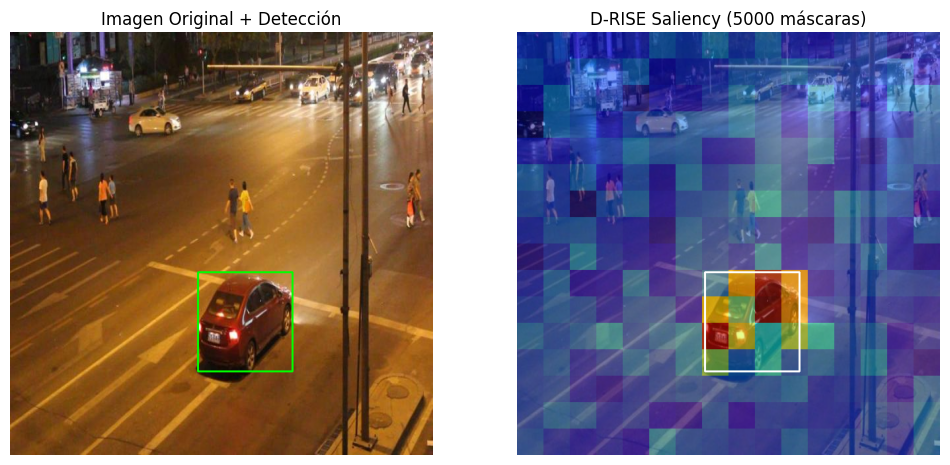

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from ultralytics import YOLO
from tqdm import tqdm

# ================= CONFIGURACIÓN =================
# Ruta exacta de tu modelo Fold 3
MODEL_PATH = "/home/alumno/Desktop/datos/Computer_vision/final_project/runs/kfold_distorted/fold_3/weights/best.pt"

# Ruta de la imagen que quieres explicar (CAMBIA ESTO por una imagen de tu test set)
# Ejemplo:
IMAGE_PATH = "/home/alumno/Desktop/datos/Computer_vision/final_project/UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/valid/images/MVI_40792_img00832_jpg.rf.fad0e5be1513d315349f8b4baa1c9944.jpg"

# Parámetros D-RISE
NUM_MASKS = 5000      # Cantidad de máscaras (1000 es rápido, 5000 es alta calidad para paper)
GRID_SIZE = (16, 16)  # Resolución de la cuadrícula de la máscara (8x8 es grueso, 16x16 es fino)
PROB_MASK = 0.5       # Probabilidad de ocultar una zona

OUTPUT_NAME = "drise_result_fold3.png"
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# ================= FUNCIONES =================

def generate_mask(image_size, grid_size, prob):
    """Genera una máscara binaria aleatoria de baja resolución y la escala."""
    h, w = image_size
    gh, gw = grid_size
    mask = (np.random.rand(gh, gw) > prob).astype(np.float32)
    mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)
    return mask

def get_iou(box1, box2):
    """Calcula IoU entre dos cajas [x1, y1, x2, y2]."""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    return intersection / (area1 + area2 - intersection + 1e-6)

def run_drise(model, img_path, num_masks=1000):
    print(f"Cargando imagen: {img_path}")
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("No se encontró la imagen.")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    # 1. Obtener detección ORIGINAL (Ground Truth para D-RISE)
    print("Obteniendo predicción base...")
    results = model.predict(img_rgb, verbose=False, conf=0.5)
    
    if len(results[0].boxes) == 0:
        print("⚠️ El modelo no detectó nada en la imagen original. No se puede explicar.")
        return
    
    # Seleccionamos el objeto con mayor confianza para explicarlo
    best_box = results[0].boxes[0]
    target_box = best_box.xyxy[0].cpu().numpy() # [x1, y1, x2, y2]
    target_cls = int(best_box.cls)
    print(f"Explicando objeto: Clase {target_cls} en {target_box}")

    # Inicializar mapa de calor acumulado
    saliency_map = np.zeros((h, w), dtype=np.float32)

    # 2. Bucle D-RISE
    print(f"Generando {num_masks} máscaras y ejecutando inferencia...")
    
    # Pre-generar algunas máscaras para no hacerlo dentro del bucle si fuera necesario,
    # pero aquí lo hacemos on-the-fly para ahorrar RAM.
    
    for _ in tqdm(range(num_masks)):
        # A. Crear máscara
        mask = generate_mask((h, w), GRID_SIZE, PROB_MASK)
        
        # B. Aplicar máscara a la imagen
        # Expandimos dims para broadcasting: (H,W,3) * (H,W,1)
        masked_img = (img_rgb * mask[:, :, np.newaxis]).astype(np.uint8)
        
        # C. Inferencia
        res_masked = model.predict(masked_img, verbose=False, conf=0.25)
        
        # D. Buscar la mejor coincidencia con nuestra caja original
        max_score = 0
        
        if len(res_masked[0].boxes) > 0:
            for box in res_masked[0].boxes:
                # Solo nos importa si detecta la MISMA clase
                if int(box.cls) == target_cls:
                    pred_box = box.xyxy[0].cpu().numpy()
                    conf = float(box.conf)
                    
                    # Score = IoU * Confianza
                    iou = get_iou(target_box, pred_box)
                    score = iou * conf
                    
                    if score > max_score:
                        max_score = score
        
        # E. Actualizar mapa de calor
        # Sumamos la máscara ponderada por qué tan bien detectó el objeto
        saliency_map += mask * max_score

    # 3. Normalizar y Visualizar
    print("Generando visualización...")
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min() + 1e-8)
    
    # Crear colormap
    heatmap = cv2.applyColorMap(np.uint8(255 * saliency_map), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # Superponer
    overlay = cv2.addWeighted(img_rgb, 0.5, heatmap, 0.5, 0)
    
    # Dibujar la caja original para referencia
    cv2.rectangle(overlay, 
                  (int(target_box[0]), int(target_box[1])), 
                  (int(target_box[2]), int(target_box[3])), 
                  (255, 255, 255), 2)

    # Guardar
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title("Imagen Original + Detección")
    img_box = img_rgb.copy()
    cv2.rectangle(img_box, 
                  (int(target_box[0]), int(target_box[1])), 
                  (int(target_box[2]), int(target_box[3])), 
                  (0, 255, 0), 2)
    plt.imshow(img_box)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title(f"D-RISE Saliency ({num_masks} máscaras)")
    plt.imshow(overlay)
    plt.axis('off')
    
    plt.savefig(OUTPUT_NAME, dpi=150, bbox_inches='tight')
    print(f"✅ Resultado guardado en: {OUTPUT_NAME}")

# ================= EJECUCIÓN =================

if __name__ == "__main__":
    if not os.path.exists(MODEL_PATH):
        print("❌ Error: Ruta del modelo incorrecta.")
    else:
        # Cargar modelo una sola vez
        model = YOLO(MODEL_PATH)
        
        # IMPORTANTE: Elige una imagen de tu carpeta de test que tenga coches
        # Busca una automáticamente si no quieres poner la ruta manual:
        test_dir = "/home/alumno/Desktop/datos/Computer_vision/final_project/UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/test/images"
        if os.path.exists(test_dir):
            import glob
            posibles = glob.glob(os.path.join(test_dir, "*.jpg"))
            if posibles:
                IMAGE_PATH = posibles[0] # Coge la primera que encuentre
                print(f"Usando imagen automática: {IMAGE_PATH}")
            else:
                print("No encontré imágenes .jpg en la carpeta test.")
                exit()
        
        run_drise(model, IMAGE_PATH, num_masks=NUM_MASKS)

# Inicio uso SAHI

# Libreria SAHI Deteccion coches arcen

En primer lugar, hay que importar la libreria sahi. La importamos en la siguiente celda

In [13]:
# !uv pip install sahi

Using Python 3.13.7 environment at: /home/alumno/py313ml/.venv
Resolved 43 packages in 471ms                                        
Prepared 5 packages in 274ms                                             
Installed 5 packages in 10ms                                
 + fire==0.7.1
 + pybboxes==0.1.6
 + sahi==0.11.36
 + shapely==2.1.2
 + terminaltables==3.1.10


In [21]:
import sahi

Vamos a coger esta imagen como prueba para ver si conseguimos detectar los coches del arcen la imagen es 'MVI_20011_img00005_jpg.rf.d97da4c37520d99bca7a6cb0aed56873.jpg'. Lo que haremos sera mirar la foto como esta detectada sin sahi y con sahi. Para ver las diferencias. La ruta de la imagen es ./UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/train/images/'MVI_20011_img00005_jpg.rf.d97da4c37520d99bca7a6cb0aed56873.jpg'

## Analisis de Sahi para una única imagen

In [22]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from ultralytics import YOLO

# Importaciones de SAHI
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction
from sahi.utils.cv import visualize_object_predictions

# --- CONFIGURACIÓN DE USUARIO ---
# tipo_modelo = 'kfold'
tipo_modelo = 'kfold_distorted'
num_fold = 2

# Ruta de la imagen
img_path = "./UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/train/images/MVI_20011_img00005_jpg.rf.d97da4c37520d99bca7a6cb0aed56873.jpg"

# Ruta del modelo
model_path = f"runs/{tipo_modelo}/fold_{num_fold}/weights/best.pt" 

# Configuración de SAHI
slice_h = 160  # Tu configuración: 160px
slice_w = 160  
overlap_h = 0.2
overlap_w = 0.2
confidence = 0.6 

# --- CREAR DIRECTORIO DE GUARDADO (IMPORTANTE) ---
# Esto evita errores si la carpeta no existe
save_dir = './Fotos pruebas con sahi/Foto unica/'
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, f'Comparacion_No_Sahi_vs_Sahi_{tipo_modelo}_{slice_h}_confidence_{confidence}_overlap_{overlap_h}.png')

# --- 1. CARGAR IMAGEN ORIGINAL ---
img_raw = cv2.imread(img_path)
if img_raw is None:
    raise FileNotFoundError(f"No se encuentra la imagen: {img_path}")
# Convertir a RGB para matplotlib
img_rgb_original = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

# --- 2. PREDICCIÓN ESTÁNDAR (SIN SAHI) ---
print("Ejecutando YOLO normal...")
model = YOLO(model_path)
results_std = model(img_path, conf=confidence)

# Generar imagen pintada
res_plotted_std = results_std[0].plot() # Devuelve BGR
img_std_rgb = cv2.cvtColor(res_plotted_std, cv2.COLOR_BGR2RGB)

# --- 3. PREDICCIÓN CON SAHI ---
print(f"Ejecutando SAHI (Slice {slice_h}x{slice_w})...")

detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path=model_path,
    confidence_threshold=confidence,
    device='cuda:0' # Cambia a 'cpu' si necesario
)

result_sahi = get_sliced_prediction(
    img_path,
    detection_model,
    slice_height=slice_h,
    slice_width=slice_w,
    overlap_height_ratio=overlap_h,
    overlap_width_ratio=overlap_w
)

# Visualizar SAHI
# Pasamos la imagen original en BGR (img_raw) porque visualize_object_predictions maneja cv2 internamente
visualization_result = visualize_object_predictions(
    image=img_raw, 
    object_prediction_list=result_sahi.object_prediction_list,
    rect_th=2,
    text_size=0.4,
    text_th=1
)
# SAHI suele devolver un array RGB listo para plotear, pero por seguridad aseguramos formato numpy
img_sahi_result = visualization_result["image"] 

# --- 4. MOSTRAR Y GUARDAR (LAYOUT PIRAMIDAL) ---
plt.figure(figsize=(16, 12)) # Lienzo más alto para que quepa todo bien

# A. IMAGEN ORIGINAL (Arriba, ocupa todo el ancho)
plt.subplot(2, 1, 1)
plt.imshow(img_rgb_original)
plt.title(f"IMAGEN ORIGINAL\n{os.path.basename(img_path)}", fontsize=14, fontweight='bold')
plt.axis('off')

# B. SIN SAHI (Abajo Izquierda)
plt.subplot(2, 2, 3)
plt.imshow(img_std_rgb)
plt.title(f"YOLO Estándar (Sin SAHI)\nConf: {confidence} | Detectados: {len(results_std[0].boxes)}", fontsize=12)
plt.axis('off')

# C. CON SAHI (Abajo Derecha)
plt.subplot(2, 2, 4)
plt.imshow(img_sahi_result)
plt.title(f"YOLO + SAHI (Ventanas {slice_h}x{slice_w})\nConf: {confidence} | Detectados: {len(result_sahi.object_prediction_list)}", fontsize=12)
plt.axis('off')

plt.tight_layout()

# Guardar
print(f"Guardando resultado en: {save_path}")
plt.savefig(save_path, dpi=300)

plt.show()

Ejecutando YOLO normal...

image 1/1 /home/alumno/Desktop/datos/Computer_vision/final_project/UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/train/images/MVI_20011_img00005_jpg.rf.d97da4c37520d99bca7a6cb0aed56873.jpg: 640x640 7 cars, 4.8ms
Speed: 2.2ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Ejecutando SAHI (Slice 160x160)...
Performing prediction on 25 slices.
Guardando resultado en: ./Fotos pruebas con sahi/Foto unica/Comparacion_No_Sahi_vs_Sahi_kfold_distorted_160_confidence_0.6_overlap_0.2.png


/tmp/ipykernel_2098/616421514.py:110: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


Los mejores resultados obtenidos para el modelo sin distorsionar es kfold_3. Además con una confianza de 0.6 y un overlap de 0.2

Nos quedamos con el modelo de grid con confianza de 0.6 y luego de overlap 0.2 y tamaño de 160 x 160

## Procesamiento de todas las imagenes con las nuevas etiquetas creadas con SAHI

El siguiente codigo lo que hace es 
Pinta TODAS las cajas que ve SAHI.

- El problema: Si en una foto hay 10 coches y tú ya tenías etiquetados 9, este código te pintará 10 cajas rojas. Tendrás que jugar a "las 7 diferencias" mirando la foto para adivinar cuál es la nueva.
- Utilidad: Comprobacion de que el modelo funciona bien las fotos se guardan aqui **./Procesadas_Train_SAHI**
- El archivo py donde se ha ejecutado esto se llama Paso1_Sahi_visualización.py y se ha hecho una confianza de 0.5 

In [23]:
#Este codigo es unicamente para comprobar si el modelo funciona bien 

import os
import cv2
import glob
import numpy as np
from tqdm import tqdm # Barra de progreso
from ultralytics import YOLO

# Importaciones de SAHI
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction
from sahi.utils.cv import visualize_object_predictions

# --- CONFIGURACIÓN DE USUARIO ---
tipo_modelo = 'kfold_distorted'
num_fold = 2

# RUTAS
input_dir = "./UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/train/images/"
model_path = f"runs/{tipo_modelo}/fold_{num_fold}/weights/best.pt" 

# Configuración de SAHI
slice_h = 160 
slice_w = 160   
overlap_h = 0.2
overlap_w = 0.2
confidence = 0.5 

# --- PREPARACIÓN DEL DIRECTORIO DE SALIDA ---
# Nombre descriptivo para saber qué configuración se usó
output_folder_name = f"Train_Processed_SAHI_{slice_h}px_conf{confidence}"
output_dir = os.path.join('./Procesadas_Train_SAHI', output_folder_name)
os.makedirs(output_dir, exist_ok=True)

print(f"--- INICIANDO PROCESO MASIVO ---")
print(f"Entrada: {input_dir}")
print(f"Salida:  {output_dir}")

# --- 1. CARGAR MODELO (UNA SOLA VEZ) ---
print("Cargando modelo en memoria...")
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path=model_path,
    confidence_threshold=confidence,
    device='cuda:0' # Cambia a 'cpu' si no tienes GPU
)

# --- 2. OBTENER LISTA DE IMÁGENES ---
# Busca todas las imagenes jpg en la carpeta
img_paths = glob.glob(os.path.join(input_dir, "*.jpg"))
print(f"Se encontraron {len(img_paths)} imágenes para procesar.")

# Si quieres probar primero con pocas imágenes, descomenta la siguiente línea:
# img_paths = img_paths[:20] 

# --- 3. BUCLE DE PROCESAMIENTO ---
for img_file in tqdm(img_paths, desc="Procesando imágenes con SAHI"):
    
    # A. Leer imagen
    img_raw = cv2.imread(img_file)
    if img_raw is None:
        print(f"Error leyendo: {img_file}")
        continue
        
    # B. Predicción con SAHI (Slicing)
    result_sahi = get_sliced_prediction(
        img_file, 
        detection_model,
        slice_height=slice_h,
        slice_width=slice_w,
        overlap_height_ratio=overlap_h,
        overlap_width_ratio=overlap_w,
        verbose=0 # Silenciar logs por cada imagen
    )

    # C. Pintar las cajas en la imagen
    # visualize_object_predictions devuelve un dict con la imagen pintada
    visualization_result = visualize_object_predictions(
        image=img_raw, 
        object_prediction_list=result_sahi.object_prediction_list,
        rect_th=2,
        text_size=0.4,
        text_th=1
    )
    
    img_result = visualization_result["image"]

    # D. Convertir a BGR para guardar con OpenCV
    # SAHI/Matplotlib trabajan en RGB, OpenCV en BGR.
    # Si la imagen sale con colores raros (azul en vez de rojo), descomenta la linea de abajo:
    img_result_bgr = cv2.cvtColor(img_result, cv2.COLOR_RGB2BGR)
    
    # E. Guardar imagen
    filename = os.path.basename(img_file)
    save_path = os.path.join(output_dir, filename)
    
    cv2.imwrite(save_path, img_result_bgr)

print("\n¡Proceso terminado!")
print(f"Imágenes guardadas en: {output_dir}")

--- INICIANDO PROCESO MASIVO ---
Entrada: ./UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/train/images/
Salida:  ./Procesadas_Train_SAHI/Train_Processed_SAHI_160px_conf0.5
Cargando modelo en memoria...
Se encontraron 9316 imágenes para procesar.


Procesando imágenes con SAHI: 100%|█████████| 9316/9316 [37:00<00:00,  4.20it/s]


¡Proceso terminado!
Imágenes guardadas en: ./Procesadas_Train_SAHI/Train_Processed_SAHI_160px_conf0.5


# CODIGO PARA QUE SAHI COMPARE LAS DOS IMAGENES Y NOS QUEDAMOS LAS QUE NO ESTEN DUPLICADAS 

En el siguiente codigo lo que vamos a hacer es de los objetos nuevos que se detectan con sahi, las comparamos con los objetos que ya estaban detectados en nuestro dataset original. Si las cajas de los objetos coinciden en al menos un 30% estas cajas se eliminan ya que estan duplicadas y no debemos añadirlas porque le estariamos diciendo que ahí hay dos objetos cuando realmente solo hay 1

En la siguiente celda, eliminamos los cuadrados que tengan una confianza de mas de 0.75 

In [24]:
#CODIGO 3
import os
import cv2
import glob
import numpy as np
import matplotlib
# Configurar backend para que funcione sin monitor (Headless)
matplotlib.use('Agg') 
import matplotlib.pyplot as plt
from tqdm import tqdm
from ultralytics import YOLO

# Importaciones de SAHI
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction

# ==========================================
#        CONFIGURACIÓN DEL USUARIO
# ==========================================

# 1. Rutas ABSOLUTAS (Para seguridad en el servidor)
BASE_PROJECT_DIR = "/home/alumno/Desktop/datos/Computer_vision/final_project"
DATASET_DIR = os.path.join(BASE_PROJECT_DIR, "UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8")

input_dir = os.path.join(DATASET_DIR, "train/images")
labels_dir = os.path.join(DATASET_DIR, "train/labels")

# Configuración del modelo
tipo_modelo = 'kfold_distorted'
num_fold = 2
model_path = os.path.join(BASE_PROJECT_DIR, f"runs/{tipo_modelo}/fold_{num_fold}/weights/best.pt")

# 2. Configuración del análisis
confidence_threshold = 0.5     # Tu umbral elegido para explorar
iou_threshold_exclusion = 0.30 # Umbral estricto para ignorar duplicados

# 3. Parametros SAHI
slice_h, slice_w = 160, 160
overlap_h, overlap_w = 0.2, 0.2

# 4. Salida
output_dir_stats = os.path.join(BASE_PROJECT_DIR, "Estadisticas_SAHI")
os.makedirs(output_dir_stats, exist_ok=True)
plot_filename = os.path.join(output_dir_stats, f"Histograma_Confianza_NuevasDetecciones_IoU{iou_threshold_exclusion}.png")

# ==========================================
#           FUNCIONES AUXILIARES
# ==========================================

def get_iou(boxA, boxB):
    # Calcula Intersection over Union
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    return interArea / float(boxAArea + boxBArea - interArea + 1e-6)

def load_ground_truth(txt_path, img_w, img_h):
    gt_boxes = []
    if os.path.exists(txt_path):
        with open(txt_path, 'r') as f:
            for line in f:
                parts = list(map(float, line.strip().split()))
                if len(parts) >= 5:
                    cls, cx, cy, bw, bh = parts[:5]
                    l = int((cx - bw/2) * img_w)
                    t = int((cy - bh/2) * img_h)
                    r = int((cx + bw/2) * img_w)
                    b = int((cy + bh/2) * img_h)
                    gt_boxes.append([l, t, r, b]) # No necesitamos la clase para calcular IoU
    return gt_boxes

# ==========================================
#           LÓGICA PRINCIPAL
# ==========================================

print(f"--- INICIANDO ANÁLISIS DE HISTOGRAMA ---")
print(f"Modelo: {model_path}")
print(f"Buscando nuevas cajas con Confianza > {confidence_threshold}")
print(f"Ignorando cajas que solapen > {iou_threshold_exclusion*100}% con el Ground Truth")

# 1. CARGAR MODELO
if not os.path.exists(model_path):
    print(f"¡ERROR! No se encuentra el archivo .pt en: {model_path}")
    exit()

print("Cargando modelo...")
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path=model_path,
    confidence_threshold=confidence_threshold,
    device='cuda:0'
)

# 2. PROCESAMIENTO
img_paths = glob.glob(os.path.join(input_dir, "*.jpg"))
surviving_confidences = []

print(f"Analizando {len(img_paths)} imágenes...")

for img_file in tqdm(img_paths, desc="Calculando estadísticas"):
    # Leer imagen
    img_raw = cv2.imread(img_file)
    if img_raw is None: continue
    h, w, _ = img_raw.shape
    
    # Rutas etiquetas
    filename = os.path.basename(img_file)
    txt_name = os.path.splitext(filename)[0] + ".txt"
    txt_path = os.path.join(labels_dir, txt_name)
    
    # Cargar Ground Truth
    gt_list = load_ground_truth(txt_path, w, h)
    
    # Predicción SAHI
    result_sahi = get_sliced_prediction(
        img_file,
        detection_model,
        slice_height=slice_h,
        slice_width=slice_w,
        overlap_height_ratio=overlap_h,
        overlap_width_ratio=overlap_w,
        verbose=0
    )
    
    # Filtrado estadístico
    original_preds = result_sahi.object_prediction_list
    
    for pred in original_preds:
        pred_box = pred.bbox.to_xyxy()
        conf_value = pred.score.value 
        
        is_redundant = False
        
        # Comprobar overlap con GT
        for gt_box in gt_list:
            if get_iou(pred_box, gt_box) > iou_threshold_exclusion:
                is_redundant = True
                break 
        
        # Si NO es redundante, la contamos para la gráfica
        if not is_redundant:
            surviving_confidences.append(conf_value)

# 3. GENERAR HISTOGRAMA
print(f"\nGenerando gráfica con {len(surviving_confidences)} detecciones nuevas...")

if len(surviving_confidences) > 0:
    plt.figure(figsize=(10, 6))
    
    # Histograma
    plt.hist(surviving_confidences, bins=30, color='#4CAF50', edgecolor='black', alpha=0.7)
    
    # Líneas de media
    mean_conf = np.mean(surviving_confidences)
    plt.axvline(mean_conf, color='red', linestyle='dashed', linewidth=1, label=f'Media: {mean_conf:.2f}')
    
    plt.title(f'Confianza de Nuevas Detecciones (Filtradas)\nIoU Threshold > {iou_threshold_exclusion}', fontsize=14)
    plt.xlabel('Confianza (0.0 - 1.0)', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    # Guardar
    plt.savefig(plot_filename, dpi=300)
    print(f"✅ GRÁFICA GUARDADA EN: {plot_filename}")
    
    # Print Estadísticas
    print("\n--- ESTADÍSTICAS FINALES ---")
    print(f"Total nuevas cajas encontradas: {len(surviving_confidences)}")
    print(f"Confianza Promedio: {mean_conf:.4f}")
    print(f"Mínima: {np.min(surviving_confidences):.4f}")
    print(f"Máxima: {np.max(surviving_confidences):.4f}")

else:
    print("❌ No se encontraron cajas nuevas con estos parámetros.")

print("\nFin del programa.")

--- INICIANDO ANÁLISIS DE HISTOGRAMA ---
Modelo: /home/alumno/Desktop/datos/Computer_vision/final_project/runs/kfold_distorted/fold_2/weights/best.pt
Buscando nuevas cajas con Confianza > 0.5
Ignorando cajas que solapen > 30.0% con el Ground Truth
Cargando modelo...
Analizando 9316 imágenes...


Calculando estadísticas:  39%|█████▍        | 3608/9316 [14:00<22:09,  4.29it/s]


KeyboardInterrupt: 

In [ ]:
#Codigo 1
#Compararción objetos imagenes originales e imagenes nuevas
import os
import cv2
import glob
import numpy as np
from tqdm import tqdm
from ultralytics import YOLO

# Importaciones de SAHI
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction
from sahi.utils.cv import visualize_object_predictions

# --- CONFIGURACIÓN DE USUARIO ---
tipo_modelo = 'kfold_distorted'
num_fold = 2
confidence = 0.5

# RUTAS
input_dir = "./UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/train/images/"
labels_dir = "./UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/train/labels/" 
model_path = f"runs/{tipo_modelo}/fold_{num_fold}/weights/best.pt" 

# CONFIGURACIÓN SAHI
slice_h, slice_w = 160, 160
overlap_h, overlap_w = 0.2, 0.2

# --- CONFIGURACIÓN DE FILTRADO ---
# Subimos a 0.30. Significa que las cajas deben coincidir en un 30% de su área para considerarse duplicadas.
iou_threshold_exclusion = 0.30 

# Salida
output_folder_name = f"Train_SAHI_Only_New_Detections_IoU{iou_threshold_exclusion}"
output_dir = os.path.join('./Procesadas_Train_SAHI_Filtradas', output_folder_name)
os.makedirs(output_dir, exist_ok=True)

print(f"--- INICIANDO PROCESO DE DETECCIÓN DE ETIQUETAS FALTANTES ---")
print(f"Umbral IoU: {iou_threshold_exclusion}")
print(f"Condición: Se eliminará la caja si se solapan, SIN importar la clase.")

# --- FUNCIONES ---

def get_iou(boxA, boxB):
    # box format: [x1, y1, x2, y2]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    return interArea / float(boxAArea + boxBArea - interArea + 1e-6)

def load_ground_truth(img_path, labels_folder, img_w, img_h):
    filename = os.path.basename(img_path)
    txt_name = os.path.splitext(filename)[0] + ".txt"
    txt_path = os.path.join(labels_folder, txt_name)
    
    gt_boxes = []
    if os.path.exists(txt_path):
        with open(txt_path, 'r') as f:
            for line in f:
                parts = list(map(float, line.strip().split()))
                if len(parts) >= 5:
                    cls, cx, cy, bw, bh = parts[:5]
                    l = int((cx - bw/2) * img_w)
                    t = int((cy - bh/2) * img_h)
                    r = int((cx + bw/2) * img_w)
                    b = int((cy + bh/2) * img_h)
                    gt_boxes.append([l, t, r, b, int(cls)])
    return gt_boxes

# --- CARGAR MODELO ---
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path=model_path,
    confidence_threshold=confidence,
    device='cuda:0' 
)

# --- PROCESO ---
img_paths = glob.glob(os.path.join(input_dir, "*.jpg"))
saved_count = 0

for img_file in tqdm(img_paths, desc="Buscando objetos no etiquetados"):
    
    img_raw = cv2.imread(img_file)
    if img_raw is None: continue
    h, w, _ = img_raw.shape
    
    # 1. Cargar GT
    gt_list = load_ground_truth(img_file, labels_dir, w, h)
    
    # 2. Predicciones SAHI
    result_sahi = get_sliced_prediction(
        img_file,
        detection_model,
        slice_height=slice_h,
        slice_width=slice_w,
        overlap_height_ratio=overlap_h,
        overlap_width_ratio=overlap_w,
        verbose=0
    )
    
    # 3. FILTRADO
    filtered_predictions = []
    original_preds = result_sahi.object_prediction_list
    
    for pred in original_preds:
    
        # Esto devuelve una lista [min_x, min_y, max_x, max_y]
        pred_box = pred.bbox.to_xyxy() 
        
        is_redundant = False
        
        # Comparar con cada caja del Ground Truth
        for gt in gt_list:
            gt_box = gt[:4] # [x1, y1, x2, y2]
            
            # Calculamos IoU
            iou = get_iou(pred_box, gt_box)
            
            # Si se solapan mucho, marcamos como redundante (borrar)
            # Ignoramos la clase (gt[4]) como pediste
            if iou > iou_threshold_exclusion:
                is_redundant = True
                break 
        
        if not is_redundant:
            filtered_predictions.append(pred)

    # 4. CONDICIÓN DE GUARDADO: Solo si quedan cajas nuevas
    if len(filtered_predictions) > 0:
        
        # Pintar
        visualization_result = visualize_object_predictions(
            image=img_raw, 
            object_prediction_list=filtered_predictions,
            rect_th=2,
            text_size=0.4,
            text_th=1
        )
        img_result = visualization_result["image"]
        img_result_bgr = cv2.cvtColor(img_result, cv2.COLOR_RGB2BGR)
        
        # Texto indicativo
        cv2.putText(img_result_bgr, f"Nuevos encontrados: {len(filtered_predictions)}", 
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        
        # Guardar
        filename = os.path.basename(img_file)
        save_path = os.path.join(output_dir, filename)
        cv2.imwrite(save_path, img_result_bgr)
        saved_count += 1

print("\n--- FINALIZADO ---")
print(f"Total imágenes procesadas: {len(img_paths)}")
print(f"Imágenes con nuevas detecciones guardadas: {saved_count}")
print(f"Carpeta: {output_dir}")

Ahora vamos a ver el histograma y decidimos que vamos a seleccionar unicamente las cajas que tienen una confianza igual o mayor a 0.75. COmentar que hemos elegido de threshold 0.75 para que nos pueda detectar los coches de los laterales.


In [ ]:
#Codigo 4 
import os
import cv2
import glob
import shutil
from tqdm import tqdm
from ultralytics import YOLO

# Importaciones de SAHI
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction

# --- CONFIGURACIÓN CRÍTICA ---
# Ajusta esto basándote en el histograma que obtengas
CONFIDENCE_MINIMA_PARA_ACEPTAR = 0.75 

# Configuración del modelo y rutas
tipo_modelo = 'kfold_distorted'
num_fold = 2
confidence_model = 0.5 # Umbral bajo para que SAHI detecte, luego filtramos nosotros arriba

# RUTAS (Usa absolutas para evitar problemas)
BASE_DIR = "/home/alumno/Desktop/datos/Computer_vision/final_project"
INPUT_IMGS = os.path.join(BASE_DIR, "UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/train/images/")
INPUT_LABELS = os.path.join(BASE_DIR, "UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/train/labels/")
MODEL_PATH = os.path.join(BASE_DIR, f"runs/{tipo_modelo}/fold_{num_fold}/weights/best.pt")

# Parametros SAHI y Filtrado
slice_h, slice_w = 160, 160
overlap_h, overlap_w = 0.2, 0.2
IOU_DUPLICADOS = 0.30 # Si se solapa más de esto con una etiqueta real, NO la añadimos

# --- 1. HACER BACKUP DE SEGURIDAD (VITAL) ---
backup_dir = INPUT_LABELS + "_BACKUP_ORIGINAL"
if not os.path.exists(backup_dir):
    print(f"Creando copia de seguridad de las etiquetas en: {backup_dir}")
    shutil.copytree(INPUT_LABELS, backup_dir)
else:
    print(f"Ya existe una copia de seguridad en: {backup_dir}. Seguimos.")

# --- FUNCIONES ---

def get_iou(boxA, boxB):
    # box format: [x1, y1, x2, y2]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    return interArea / float(boxAArea + boxBArea - interArea + 1e-6)

def xyxy_to_yolo(box, img_w, img_h):
    """Convierte [x1, y1, x2, y2] a formato YOLO [x_center, y_center, width, height] normalizado"""
    x1, y1, x2, y2 = box
    dw = 1. / img_w
    dh = 1. / img_h
    x = (x1 + x2) / 2.0
    y = (y1 + y2) / 2.0
    w = x2 - x1
    h = y2 - y1
    
    # Normalizar
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return x, y, w, h

def load_ground_truth(txt_path, img_w, img_h):
    gt_boxes = []
    if os.path.exists(txt_path):
        with open(txt_path, 'r') as f:
            for line in f:
                parts = list(map(float, line.strip().split()))
                if len(parts) >= 5:
                    cls, cx, cy, bw, bh = parts[:5]
                    l = int((cx - bw/2) * img_w)
                    t = int((cy - bh/2) * img_h)
                    r = int((cx + bw/2) * img_w)
                    b = int((cy + bh/2) * img_h)
                    gt_boxes.append([l, t, r, b, int(cls)])
    return gt_boxes

# --- CARGAR MODELO ---
print("Cargando modelo...")
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path=MODEL_PATH,
    confidence_threshold=confidence_model,
    device='cuda:0'
)

# --- PROCESO PRINCIPAL ---
img_paths = glob.glob(os.path.join(INPUT_IMGS, "*.jpg"))
total_added = 0

print(f"Comenzando actualización de {len(img_paths)} archivos...")
print(f"Criterio: Confianza > {CONFIDENCE_MINIMA_PARA_ACEPTAR} y NO solaparse con GT.")

for img_file in tqdm(img_paths, desc="Actualizando Labels"):
    # Rutas y dimensiones
    filename = os.path.basename(img_file)
    txt_name = os.path.splitext(filename)[0] + ".txt"
    txt_path = os.path.join(INPUT_LABELS, txt_name)
    
    img_raw = cv2.imread(img_file)
    if img_raw is None: continue
    h, w, _ = img_raw.shape
    
    # 1. Cargar etiquetas existentes
    gt_boxes = load_ground_truth(txt_path, w, h)
    
    # 2. Obtener nuevas predicciones
    result_sahi = get_sliced_prediction(
        img_file,
        detection_model,
        slice_height=slice_h,
        slice_width=slice_w,
        overlap_height_ratio=overlap_h,
        overlap_width_ratio=overlap_w,
        verbose=0
    )
    
    new_lines_to_add = []
    
    # 3. Filtrar y Preparar
    for pred in result_sahi.object_prediction_list:
        conf = pred.score.value
        
        # FILTRO 1: ¿Es lo suficientemente fiable?
        if conf < CONFIDENCE_MINIMA_PARA_ACEPTAR:
            continue
            
        # Coordenadas y Clase
        pred_box_xyxy = pred.bbox.to_xyxy()
        cls_id = pred.category.id
        
        # FILTRO 2: ¿Ya existe en el GT? (Duplicados)
        is_duplicate = False
        for gt in gt_boxes:
            gt_box_xyxy = gt[:4]
            if get_iou(pred_box_xyxy, gt_box_xyxy) > IOU_DUPLICADOS:
                is_duplicate = True
                break
        
        if is_duplicate:
            continue
            
        # ¡ES NUEVA Y FIABLE! -> Convertir a formato YOLO para guardar
        x_c, y_c, bw, bh = xyxy_to_yolo(pred_box_xyxy, w, h)
        
        # Formato string: class x_center y_center width height
        line_str = f"{int(cls_id)} {x_c:.6f} {y_c:.6f} {bw:.6f} {bh:.6f}\n"
        new_lines_to_add.append(line_str)
        
    # 4. Escribir en el archivo (Append)
    if new_lines_to_add:
        # Abrimos en modo 'a' (append) para añadir al final
        with open(txt_path, 'a') as f:
            for line in new_lines_to_add:
                f.write(line)
        total_added += len(new_lines_to_add)

print("\n--- PROCESO TERMINADO ---")
print(f"Se han añadido {total_added} nuevas etiquetas al dataset.")
print(f"Tus etiquetas originales están a salvo en: {backup_dir}")

https://www.youtube.com/@TrafficCamWatch/videos

Cosas que quedan para hacer:
- D Rise de lo que hemos obtenido
- Sacar todos los resultados del test y graficos como matriz de confusión
- Usar el video para ver si predice el coche accidentado

Lo que vamos ha hacer es probar el mejor modelo obtenido hasta pero sin coger los mejores pesos. También como tenemos 9316 imagenes de entrenamiento. Quiero sacar mismos porcentajes de entrenamiento y validación que hemos usado hasta ahora como tenemos k = 5 vamos a usar un 80% training y 20 % validation. Vamos a hacer la separación estratificada nuevamente ya que las proporciones han podido cambiar por lo tanto es necesario hacer 

Al aplicar SAHI se han obtenido nuevos objetos detectados por lo tanto, es necesario hacer un nuevo mapa de prioridades de los datos por si hubieran cambiado las proporciones de los nuevos datos. Ahora vamos a probar el mejor modelo obtenido pero sin coger los mejores pesos. Además, si solo ejecutamos el modelo con una partición simple (80/20), el 20% de tus datos (y por tanto, el 20% de las nuevas etiquetas que SAHI ha encontrado) se irán a Validación. El modelo nunca entrenará con ellas.

In [1]:
import os
import glob
import yaml
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold

# ==========================================
#        CONFIGURACIÓN
# ==========================================

# 1. RUTA DEL DATASET ACTUALIZADO (Donde SAHI escribió los cambios)
BASE_PROJECT_DIR = "/home/alumno/Desktop/datos/Computer_vision/final_project"
dataset_path = os.path.join(BASE_PROJECT_DIR, "UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8")

num_folds = 5

# 2. TUS CLASES
class_names = {0: 'bus', 1: 'car', 2: 'truck', 3: 'van'}

# 3. MAPA DE PRIORIDADES (Para equilibrar clases difíciles)
priority_map = {
    0: 0,  # Bus    -> Prioridad MÁXIMA
    2: 1,  # Truck  -> Prioridad MEDIA
    3: 1,  # Van    -> Prioridad MEDIA
    1: 2   # Car    -> Prioridad BAJA
}

# ==========================================
#           LOGICA DEL PROGRAMA
# ==========================================

print(f"--- GENERANDO {num_folds} FOLDS ESTRATIFICADOS ---")
print(f"Dataset: {dataset_path}")

# 1. Buscar imágenes (Definimos específicamente la carpeta de entrenamiento)
train_dir = os.path.join(dataset_path, "train/images")

# Primero probamos búsqueda directa
images = glob.glob(os.path.join(train_dir, '*.jpg'))

# Si no encuentra nada, buscamos recursivamente PERO SOLO dentro de train
if len(images) == 0:
    print("Buscando recursivamente DENTRO de train/images...")
    images = glob.glob(os.path.join(train_dir, '**', '*.jpg'), recursive=True)

print(f"Imágenes cargadas para Training: {len(images)}")

print(f"Imágenes encontradas: {len(images)}")

data = []

# 2. Calcular prioridad de cada imagen (leyendo los txt modificados)
print("Analizando etiquetas...")
for img_path in images:
    label_path = img_path.replace('/images/', '/labels/').replace('.jpg', '.txt')
    assigned_priority = 99 
    
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
        
        if lines:
            try:
                classes_in_img = set([int(line.split()[0]) for line in lines])
            except:
                classes_in_img = set()
            
            best_prio = 99
            for c in classes_in_img:
                p = priority_map.get(c, 10) 
                if p < best_prio:
                    best_prio = p
            assigned_priority = best_prio
        else:
             assigned_priority = 99
    else:
        assigned_priority = 99

    data.append({
        'path': os.path.abspath(img_path), 
        'priority_group': assigned_priority
    })

df = pd.DataFrame(data)

print("--- Distribución de Prioridades ---")
print(df['priority_group'].value_counts().sort_index())

# 3. Generar los Folds
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Carpeta de salida para los yamls
folds_output_dir = os.path.join(BASE_PROJECT_DIR, "folds_final_sahi")
os.makedirs(folds_output_dir, exist_ok=True)

X = df['path']
y = df['priority_group']

print(f"\nGuardando configuración en: {folds_output_dir}")

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    # Obtener listas de archivos
    train_files = df.iloc[train_idx]['path'].tolist()
    val_files = df.iloc[val_idx]['path'].tolist()
    
    # Rutas para los txt de lista
    train_txt = os.path.join(folds_output_dir, f'train_fold_{fold_idx}.txt')
    val_txt = os.path.join(folds_output_dir, f'val_fold_{fold_idx}.txt')
    
    # Escribir txts
    with open(train_txt, 'w') as f:
        f.write('\n'.join(train_files))
    with open(val_txt, 'w') as f:
        f.write('\n'.join(val_files))
        
    # Crear YAML
    yaml_content = {
        'path': dataset_path, # Ruta base (opcional si usas rutas absolutas en txt)
        'train': train_txt,
        'val': val_txt,
        'names': class_names
    }
    
    yaml_filename = os.path.join(folds_output_dir, f'fold_{fold_idx}.yaml')
    with open(yaml_filename, 'w') as f:
        yaml.dump(yaml_content, f, sort_keys=False)

print(f"\n✅ ¡Proceso completado! Tienes 5 archivos YAML listos para entrenar.")

--- GENERANDO 5 FOLDS ESTRATIFICADOS ---
Dataset: /home/alumno/Desktop/datos/Computer_vision/final_project/UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8
Imágenes cargadas para Training: 9316
Imágenes encontradas: 9316
Analizando etiquetas...
--- Distribución de Prioridades ---
priority_group
0    1416
1    5419
2    2481
Name: count, dtype: int64

Guardando configuración en: /home/alumno/Desktop/datos/Computer_vision/final_project/folds_final_sahi

✅ ¡Proceso completado! Tienes 5 archivos YAML listos para entrenar.


Se obtienen mismas proporciones esto tiene sentido ya que para que cambiaran las proporciones se debería obterner un van o truck en una foto con solo coches o que en una foto de las nuevas etiquetas se haya detectado un autobus

In [3]:
print (f'Ants prop: {1350 + 5063 +2903}')

Ants prop: 9316


In [6]:
print (f'Despues prop: {1416 + 5419 + 2481 }')
dif_bus = 1416-1350
dif_truck_van = 5419 - 5063
dif_car = 2481 - 2903
print (f'El número de prioridades de las clases ha cambiado así: \nNúmero de buses en {dif_bus},\nNúmero de truck o van es {dif_truck_van},\nNúmero de prioridades de coche es {dif_car}')

Despues prop: 9316
El número de prioridades de las clases ha cambiado así: 
Número de buses en 66,
Número de truck o van es 356,
Número de prioridades de coche es -422


Comprobamos si realmente se han añadido las etiquetas correctamente 

In [3]:
import os
import pandas as pd
import albumentations as A
from ultralytics import YOLO

# ==========================================
#        CONFIGURACIÓN
# ==========================================

# 1. Rutas
# IMPORTANTE: Aquí ponemos la carpeta que generó tu script de K-Fold anterior
folds_dir = 'folds_final_sahi' 
project_name = 'runs/kfold_final_sahi' # Nombre nuevo para no mezclar con pruebas anteriores
model_name = "yolov8n.pt"

# 2. Hiperparámetros (Mismos que con k fold distortioned)
num_folds = 5  
epochs = 10       
img_size = 640
batch_size = 16

# 3. Transformaciones (Albumentations)
custom_transforms = [
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, p=0.5),
    A.GaussNoise(p=0.3),
]

# Lista para guardar métricas finales
results_summary = [] 

# ==========================================
#        BUCLE DE ENTRENAMIENTO
# ==========================================

print(f"--- INICIANDO ENTRENAMIENTO FINAL (SAHI) ---")
print(f"Leyendo Folds desde: {folds_dir}")
print(f"Guardando resultados en: {project_name}")

if not os.path.exists(folds_dir):
    print(f"❌ ERROR CRÍTICO: No existe la carpeta '{folds_dir}'.")
    print("Asegúrate de haber ejecutado el script de generación de Folds primero.")
    exit()

for k in range(num_folds):
    yaml_file = os.path.join(folds_dir, f'fold_{k}.yaml')
    run_name = f'fold_{k}'
    
    if not os.path.exists(yaml_file): 
        print(f"⚠️ Aviso: No se encuentra {yaml_file}, saltando...")
        continue

    print(f"\nTraining Fold {k} / {num_folds - 1}...")
    
    # 1. Cargar modelo base limpio
    model = YOLO(model_name)
    
    # 2. Entrenar
    try:
        model.train(
            data=yaml_file,
            epochs=epochs,
            imgsz=img_size,
            batch=batch_size,
            project=project_name,
            name=run_name,
            patience=10, 
            verbose=True,
            exist_ok=True,
            augmentations=custom_transforms, 
            seed=42,
            deterministic=True,
            workers=4,
            degrees=0.0,
            mosaic=0.0,      
            mixup=0.0,        
            copy_paste=0.0   
        )
    except Exception as e:
        print(f"❌ Error entrenando Fold {k}: {e}")
        continue

    # 3. Extraer métricas del CSV generado
    results_path = os.path.join(project_name, run_name, 'results.csv')
    
    if os.path.exists(results_path):
        df = pd.read_csv(results_path)
        df.columns = df.columns.str.strip()
        
        # Mejor época según mAP50
        best_idx = df['metrics/mAP50(B)'].idxmax()
        best_epoch_data = df.iloc[best_idx]
        
        results_summary.append({
            'Fold': k,
            'Precision': best_epoch_data['metrics/precision(B)'],
            'Recall': best_epoch_data['metrics/recall(B)'],
            'mAP@50': best_epoch_data['metrics/mAP50(B)'],
            'mAP@50-95': best_epoch_data['metrics/mAP50-95(B)']
        })
        
        print(f"-> Fold {k}: Mejor mAP@50: {best_epoch_data['metrics/mAP50(B)']:.4f}")
    else:
        print(f"⚠️ No se encontró CSV de resultados para el Fold {k}")

# ==========================================
#        RESUMEN FINAL
# ==========================================

if results_summary:
    df_final = pd.DataFrame(results_summary)
    df_final.set_index('Fold', inplace=True)

    # Calcular promedio
    df_final.loc['PROMEDIO'] = df_final.mean()

    print("\n" + "="*50)
    print("RESUMEN DE RESULTADOS (SAHI + MEJORES HIPERPARÁMETROS)")
    print("="*50)
    print(df_final)
    print("="*50)

    # Guardar CSV final
    output_csv_name = 'resultados_finales_sahi.csv'
    df_final.to_csv(output_csv_name)
    print(f"✅ Resultados guardados en '{output_csv_name}'")
else:
    print("❌ No se generaron resultados.")

Total de archivos: 9316
TOTAL DE ETIQUETAS (CAJAS): 109505


In [1]:
# Resultado del modelo anterior

# ==================================================
# RESUMEN DE RESULTADOS (SAHI + MEJORES HIPERPARÁMETROS)
# ==================================================
#           Precision    Recall    mAP@50  mAP@50-95
# Fold
# 0          0.901190  0.848270  0.916710   0.762570
# 1          0.911780  0.841870  0.918840   0.764560
# 2          0.907280  0.837970  0.918900   0.759570
# 3          0.908530  0.832250  0.912770   0.746370
# 4          0.909110  0.837330  0.911710   0.754460
# PROMEDIO   0.907578  0.839538  0.915786   0.757506
# ==================================================
# ✅ Resultados guardados en 'resultados_finales_sahi.csv'

Evaluamos el primer modelo sin distortioned con el mejor modelo obtenido con distortioned tras haber aplicado sahi 

In [9]:
from ultralytics import YOLO
import os
import yaml

# --- CONFIGURACIÓN ---
BASE_DIR = "/home/alumno/Desktop/datos/Computer_vision/final_project"
DATASET_DIR = os.path.join(BASE_DIR, "UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8")

# Rutas de tus campeones
path_old = os.path.join(BASE_DIR, "runs/kfold/fold_3/weights/best.pt")
path_new = os.path.join(BASE_DIR, "runs/kfold_final_sahi/fold_1/weights/best.pt")

# Creamos un YAML temporal que apunte al TEST REAL (Valid folder)
yaml_test_path = "config_comparativa.yaml"
yaml_content = {
    'path': DATASET_DIR,
    'train': "train/images", # Irrelevante para val
    'val': "valid/images",   # <--- LA CLAVE: Usamos las 500 imágenes limpias
    'names': {0: 'bus', 1: 'car', 2: 'truck', 3: 'van'}
}
with open(yaml_test_path, 'w') as f:
    yaml.dump(yaml_content, f)

print("--- 🥊 INICIANDO LA BATALLA DE MODELOS 🥊 ---")

# --- EVALUAR MODELO ANTIGUO ---
if os.path.exists(path_old):
    print(f"\n1️⃣ Evaluando Modelo ANTIGUO (Sin SAHI)...")
    model_old = YOLO(path_old)
    metrics_old = model_old.val(data=yaml_test_path, split='val', verbose=False)
    map50_old = metrics_old.box.map50
    map5095_old = metrics_old.box.map
else:
    print("❌ No encuentro el modelo antiguo.")
    map50_old = 0

# --- EVALUAR MODELO NUEVO ---
if os.path.exists(path_new):
    print(f"\n2️⃣ Evaluando Modelo NUEVO (Con SAHI)...")
    model_new = YOLO(path_new)
    metrics_new = model_new.val(data=yaml_test_path, split='val', verbose=False)
    map50_new = metrics_new.box.map50
    map5095_new = metrics_new.box.map
else:
    print("❌ No encuentro el modelo nuevo.")
    map50_new = 0

# --- RESULTADOS FINALES ---
print("\n" + "="*50)
print(f"📊 RESULTADOS FINALES EN TEST (500 Imágenes)")
print("="*50)
print(f"{'Modelo':<20} | {'mAP@50':<10} | {'mAP@50-95':<10}")
print("-" * 46)
print(f"{'ANTIGUO (Pre-SAHI)':<20} | {map50_old:.4f}     | {map5095_old:.4f}")
print(f"{'NUEVO (Con SAHI)':<20} | {map50_new:.4f}     | {map5095_new:.4f}")
print("-" * 46)

diff = map50_new - map50_old
if diff > 0:
    print(f"🎉 ¡ÉXITO! El modelo con SAHI ha mejorado el mAP en +{diff:.4f}")
else:
    print(f"⚠️ El modelo antiguo gana por {abs(diff):.4f} (Revisar Falsos Positivos)")

--- 🥊 INICIANDO LA BATALLA DE MODELOS 🥊 ---

1️⃣ Evaluando Modelo ANTIGUO (Sin SAHI)...
Ultralytics 8.3.247 🚀 Python-3.13.7 torch-2.9.1+cu128 CUDA:0 (NVIDIA RTX PRO 6000 Blackwell Max-Q Workstation Edition, 97248MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.2±0.0 ms, read: 5.1±6.9 MB/s, size: 49.6 KB)
val: Scanning /home/alumno/Desktop/datos/Computer_vision/final_project/UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/valid/labels... 500 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 500/500 463.8it/s 1.1s0.0s
val: New cache created: /home/alumno/Desktop/datos/Computer_vision/final_project/UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/valid/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 32/32 10.8it/s 3.0s0.1s
                   all        500       4845      0.927      0.892      0.949      0.818
Speed: 0.8ms preprocess, 0.6ms in

In [12]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os
import glob
import random
from tqdm import tqdm

# ==========================================
#              CONFIGURACIÓN
# ==========================================
BASE_DIR = "/home/alumno/Desktop/datos/Computer_vision/final_project"
IMG_DIR = os.path.join(BASE_DIR, "UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/valid/images")
OUTPUT_FOLDER = "evidencias_finales" # Carpeta donde se guardarán las fotos

# Tus modelos
path_old = os.path.join(BASE_DIR, "runs/kfold/fold_3/weights/best.pt")
path_new = os.path.join(BASE_DIR, "runs/kfold_final_sahi/fold_1/weights/best.pt")

target_count = 10  # <--- AHORA BUSCAMOS 10
min_difference = 2 # El nuevo tiene que ver al menos 2 coches más para que valga

# ==========================================
#                 LÓGICA
# ==========================================

# 1. Preparar entorno
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
print(f"--- 🕵️‍♂️ BUSCANDO {target_count} EVIDENCIAS VISUALES ---")
print(f"Guardando en carpeta: {OUTPUT_FOLDER}/")

print("Cargando modelos...")
model_old = YOLO(path_old)
model_new = YOLO(path_new)

# 2. Obtener imágenes y mezclar
all_images = glob.glob(os.path.join(IMG_DIR, "*.jpg"))
random.shuffle(all_images)

if not all_images:
    print("❌ Error: No hay imágenes en la carpeta valid.")
    exit()

print(f"Escaneando {len(all_images)} imágenes de test...")

found_count = 0

# 3. Bucle de Búsqueda
for img_path in tqdm(all_images):
    if found_count >= target_count:
        break # Ya tenemos las 10
        
    # --- Predicción Rápida (Solo conteo) ---
    res_old = model_old.predict(img_path, conf=0.5, verbose=False)
    res_new = model_new.predict(img_path, conf=0.5, verbose=False)
    
    count_old = len(res_old[0].boxes)
    count_new = len(res_new[0].boxes)
    
    # --- FILTRO: ¿Es interesante? ---
    # Queremos que el NUEVO gane por diferencia
    if count_new >= count_old + min_difference:
        
        # ¡La encontramos! Ahora la pintamos bonito
        filename = os.path.basename(img_path)
        
        # Preparar Gráfica Lado a Lado
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        
        # VIEJO
        plot_old = res_old[0].plot() # BGR
        plot_old = cv2.cvtColor(plot_old, cv2.COLOR_BGR2RGB)
        axes[0].imshow(plot_old)
        axes[0].set_title(f"ANTIGUO (Fold 3)\nDetectados: {count_old}", fontsize=16, color='red')
        axes[0].axis('off')
        
        # NUEVO
        plot_new = res_new[0].plot() # BGR
        plot_new = cv2.cvtColor(plot_new, cv2.COLOR_BGR2RGB)
        axes[1].imshow(plot_new)
        axes[1].set_title(f"NUEVO (SAHI - Fold 1)\nDetectados: {count_new} (+{count_new-count_old})", fontsize=16, color='green')
        axes[1].axis('off')
        
        # Guardar archivo individual
        save_path = os.path.join(OUTPUT_FOLDER, f"evidencia_{found_count+1}_{filename}")
        plt.tight_layout()
        plt.savefig(save_path)
        plt.close(fig) # Liberar memoria
        
        found_count += 1

# ==========================================
#              RESUMEN
# ==========================================
if found_count == 0:
    print("❌ Vaya... No encontré ninguna imagen con tanta diferencia.")
    print("Prueba a bajar 'min_difference' a 1.")
else:
    print(f"\n✅ ¡ÉXITO! Se han guardado {found_count} imágenes en la carpeta '{OUTPUT_FOLDER}'.")
    print("Entra ahí y elige las que más te gusten para tu presentación.")

--- 🕵️‍♂️ BUSCANDO 10 EVIDENCIAS VISUALES ---
Guardando en carpeta: evidencias_finales/
Cargando modelos...
Escaneando 500 imágenes de test...


  3%|█▎                                        | 16/500 [00:02<01:25,  5.69it/s]


✅ ¡ÉXITO! Se han guardado 10 imágenes en la carpeta 'evidencias_finales'.
Entra ahí y elige las que más te gusten para tu presentación.


In [24]:
from ultralytics import YOLO
import os
import yaml
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# ==========================================
#              CONFIGURACIÓN
# ==========================================
BASE_DIR = "/home/alumno/Desktop/datos/Computer_vision/final_project"
DATASET_DIR = os.path.join(BASE_DIR, "UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8")

# Tu MEJOR modelo (Fold 1 con SAHI)
MODEL_PATH = os.path.join(BASE_DIR, "runs/kfold_final_sahi/fold_1/weights/best.pt")

# Carpeta donde se guardarán los resultados (incluida la matriz)
PROJECT_PATH = "runs/analisis_final"
NAME_PATH = "matriz_confusion"

# ==========================================
#           PREPARACIÓN DEL TEST
# ==========================================

# 1. Crear YAML temporal apuntando a VALID (Test limpio)
yaml_test_path = "config_matriz.yaml"
yaml_content = {
    'path': DATASET_DIR,
    'train': "train/images", 
    'val': "valid/images",   # <--- TUS DATOS DE TEST
    'names': {0: 'bus', 1: 'car', 2: 'truck', 3: 'van'}
}
with open(yaml_test_path, 'w') as f:
    yaml.dump(yaml_content, f)

# ==========================================
#           GENERACIÓN DE LA MATRIZ
# ==========================================
print(f"--- 📊 GENERANDO MATRIZ DE CONFUSIÓN ---")
print(f"Modelo: {MODEL_PATH}")

if not os.path.exists(MODEL_PATH):
    print("❌ Error: No encuentro el archivo del modelo.")
    exit()

model = YOLO(MODEL_PATH)

# plots=True es OBLIGATORIO para que guarde la matriz como imagen
metrics = model.val(
    data=yaml_test_path,
    split='val',
    project=PROJECT_PATH,
    name=NAME_PATH,
    plots=True,       # <--- ESTO GENERA LA MATRIZ
    conf=0.5,        # Umbral de confianza estándar
    iou=0.6,          # Umbral de IoU estándar
    imgsz=640,
    save_json=True
)

# ==========================================
#           MOSTRAR RESULTADO
# ==========================================
# Ruta donde YOLO guarda la imagen
save_dir = metrics.save_dir # Ruta completa (ej: runs/analisis_final/matriz_confusion)
cm_path = os.path.join(save_dir, "confusion_matrix_normalized.png")

print("\n" + "="*50)
if os.path.exists(cm_path):
    print(f"✅ ¡ÉXITO! Matriz guardada en:")
    print(f"   📂 {cm_path}")
    print("="*50)
    
    # Intentar mostrarla si estás en un entorno gráfico (Jupyter/Spyder)
    try:
        img = mpimg.imread(cm_path)
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title("Matriz de Confusión Normalizada")
        plt.show()
        print("📸 Mostrando imagen...")
    except:
        print("💡 Abre la imagen manualmente para analizarla.")
else:
    print(f"⚠️ No encuentro la imagen en {cm_path}")
    print(f"Busca en la carpeta: {save_dir}")

--- 📊 GENERANDO MATRIZ DE CONFUSIÓN ---
Modelo: /home/alumno/Desktop/datos/Computer_vision/final_project/runs/kfold_final_sahi/fold_1/weights/best.pt
Ultralytics 8.3.247 🚀 Python-3.13.7 torch-2.9.1+cu128 CUDA:0 (NVIDIA RTX PRO 6000 Blackwell Max-Q Workstation Edition, 97248MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.1±0.0 ms, read: 217.6±21.7 MB/s, size: 52.4 KB)
val: Scanning /home/alumno/Desktop/datos/Computer_vision/final_project/UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/valid/labels.cache... 500 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 500/500 835.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 32/32 9.7it/s 3.3s<0.1s
                   all        500       4845      0.856      0.845      0.896      0.791
                   bus         94         96      0.938      0.781      0.893       0.79
                   car    

<Figure size 1000x1000 with 1 Axes>

📸 Mostrando imagen...


Aplicamos D-RISE sobre el mejor modelo obtenido. Se realizan 2 experimentos. En ambos experimentos se realizan 5000 máscaras. En el experimento 1 se usa un tamaño de la máscara de 16 x 16 y en el segundo experimento se va a usar un tamaño de 32 x 32. Estos experimentos se guardan en una nueva carpeta que se crea por codigo que tiene como nombre "D-Rise Visualization best model". Este codigo se ha ejecutado en el archivo.py llamado **D_Rise_final_model.py**

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from ultralytics import YOLO
from tqdm import tqdm

# ---------------- CONFIGURACIÓN GENERAL ----------------

# 1. Rutas
carpeta_imagenes = '/home/alumno/Desktop/datos/Computer_vision/final_project/UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/valid/images/'
model_path = "runs/kfold_final_sahi/fold_1/weights/best.pt"

# 2. Carpeta Principal de Salida
main_output_folder = "D-Rise Visualization best model"

# 3. Lista de imágenes
list_imagen = [
    'MVI_40712_img01353_jpg.rf.eb6461427d31d27948897022f02e6d4b.jpg',
    'MVI_40763_img01708_jpg.rf.deb4b72b080d14adfbd1609fc257a395.jpg',
    'MVI_40793_img00140_jpg.rf.07876907f3449df18013e2d6908bb171.jpg',
    'MVI_40793_img01774_jpg.rf.d1d6387545fedb6e3633dc5d9ddb4d28.jpg',
    'MVI_40712_img01103_jpg.rf.b13b06dec17e3558f945ffe5e7aba898.jpg',
    'MVI_40243_img00343_jpg.rf.c757f527b04fe6f4d51d4b4439dd7d38.jpg',
    'MVI_40244_img00461_jpg.rf.e4df9f83c9174dd2dd2241573405c65a.jpg'
]

# 4. Definición de los Experimentos
# Formato: (Número de máscaras, Resolución tupla, Nombre para carpeta)
experimentos = [
    (5000, (16, 16), "16"),  # Experimento 1
    (5000, (32, 32), "32")   # Experimento 2
]

# ---------------- FUNCIONES AUXILIARES ----------------

def generate_mask(image_shape, resolution, probability):
    h, w = resolution
    mask = (np.random.rand(h, w) < probability).astype(np.float32)
    mask = cv2.resize(mask, (image_shape[1], image_shape[0]), interpolation=cv2.INTER_NEAREST)
    return mask

def iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    return intersection / (area1 + area2 - intersection + 1e-6)

# ---------------- EJECUCIÓN ----------------

# Cargar modelo una vez
print(f"🔄 Cargando modelo desde: {model_path}...")
try:
    model = YOLO(model_path)
except Exception as e:
    print(f"❌ Error fatal cargando el modelo: {e}")
    exit()

# Bucle de Experimentos
for n_masks, mask_res, res_name in experimentos:
    
    # Crear nombre de carpeta específica: Ej: D-Rise_5000_16
    folder_name = f"D-Rise_{n_masks}_{res_name}"
    full_output_path = os.path.join(main_output_folder, folder_name)
    
    os.makedirs(full_output_path, exist_ok=True)
    
    print("\n" + "="*60)
    print(f"🧪 INICIANDO EXPERIMENTO: {folder_name}")
    print(f"   - Máscaras: {n_masks}")
    print(f"   - Resolución: {mask_res}")
    print(f"   - Carpeta destino: {full_output_path}")
    print("="*60 + "\n")

    # Bucle de Imágenes
    for i, nombre_imagen in enumerate(list_imagen):
        print(f"📷 Procesando imagen {i+1}/{len(list_imagen)}: {nombre_imagen}")
        
        img_full_path = os.path.join(carpeta_imagenes, nombre_imagen)
        
        # Verificar existencia
        if not os.path.exists(img_full_path):
            print(f"   ⚠️ Archivo no encontrado, saltando: {nombre_imagen}")
            continue

        # Cargar Imagen
        img = cv2.imread(img_full_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h_img, w_img, _ = img.shape

        # 1. Detección Base (Ground Truth)
        results = model(img_rgb, verbose=False)
        
        if len(results[0].boxes) == 0:
            print("   ⚠️ El modelo no detectó nada en la imagen original. Saltando.")
            continue

        # Seleccionar mejor detección
        best_box = results[0].boxes[0]
        target_bbox = best_box.xyxy[0].cpu().numpy()
        target_class = int(best_box.cls)
        conf_original = best_box.conf.item()
        
        # Nombre de clase para el título
        class_name = model.names[target_class] if hasattr(model, 'names') else str(target_class)

        # 2. Generación D-Rise
        saliency_map = np.zeros((h_img, w_img), dtype=np.float32)
        
        # Barra de progreso para las máscaras
        for _ in tqdm(range(n_masks), desc=f"   Generando {n_masks} máscaras", leave=False):
            mask = generate_mask(img.shape, mask_res, 0.5)
            masked_img = (img_rgb * mask[:, :, np.newaxis]).astype(np.uint8)
            
            # Inferencia con umbral bajo
            m_results = model(masked_img, verbose=False, conf=0.1)
            
            score = 0
            if len(m_results[0].boxes) > 0:
                max_score = 0
                for box in m_results[0].boxes:
                    pred_bbox = box.xyxy[0].cpu().numpy()
                    pred_class = int(box.cls)
                    pred_conf = box.conf.item()
                    
                    if pred_class == target_class:
                        current_iou = iou(target_bbox, pred_bbox)
                        if current_iou > 0.5:
                            max_score = max(max_score, pred_conf * current_iou)
                score = max_score
            
            saliency_map += mask * score

        # 3. Guardar Resultado
        # Normalizar mapa
        saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min() + 1e-8)

        plt.figure(figsize=(12, 6))
        
        # Panel Izquierdo: Original
        plt.subplot(1, 2, 1)
        plt.title(f"Original: {class_name} ({conf_original:.2f})")
        img_show = img_rgb.copy()
        x1, y1, x2, y2 = map(int, target_bbox)
        cv2.rectangle(img_show, (x1, y1), (x2, y2), (0, 255, 0), 2)
        plt.imshow(img_show)
        plt.axis('off')

        # Panel Derecho: D-Rise
        plt.subplot(1, 2, 2)
        plt.title(f"Saliency (M={n_masks}, Res={res_name})")
        plt.imshow(img_rgb)
        plt.imshow(saliency_map, cmap='jet', alpha=0.5)
        plt.axis('off')

        plt.tight_layout()
        
        # Guardar archivo
        save_filename = f"drise_{i}_{nombre_imagen[:-4]}_res{res_name}.png"
        save_path = os.path.join(full_output_path, save_filename)
        
        plt.savefig(save_path, bbox_inches='tight')
        plt.close() # Importante cerrar para liberar memoria
        
        print(f"   ✅ Guardado en: {save_path}")

print("\n🏁 TODOS LOS EXPERIMENTOS FINALIZADOS.")

📂 Las imágenes resultantes se guardarán en: /home/alumno/Desktop/datos/Computer_vision/final_project/pruebas_D_Rise_finales
Cargando modelo: runs/kfold_final_sahi/fold_1/weights/best.pt...
Iniciando proceso para 7 imágenes con 100 máscaras cada una.

--- Procesando imagen 1/7: MVI_40243_img00343_jpg.rf.c757f527b04fe6f4d51d4b4439dd7d38.jpg ---
   Objetivo: Clase 0 (Conf: 0.91)


✅ Guardado resultado en: pruebas_D_Rise_finales/drise_0_MVI_40243_img00343_jpg.rf.c757f527b04fe6f4d51d4b4439dd7d38.jpg

--- Procesando imagen 2/7: MVI_40763_img01708_jpg.rf.deb4b72b080d14adfbd1609fc257a395.jpg ---
   Objetivo: Clase 1 (Conf: 0.89)


✅ Guardado resultado en: pruebas_D_Rise_finales/drise_1_MVI_40763_img01708_jpg.rf.deb4b72b080d14adfbd1609fc257a395.jpg

--- Procesando imagen 3/7: MVI_40793_img00140_jpg.rf.07876907f3449df18013e2d6908bb171.jpg ---
   Objetivo: Clase 1 (Conf: 0.95)


✅ Guardado resultado en: pruebas_D_Rise_finales/drise_2_MVI_40793_img00140_jpg.rf.07876907f3449df18013e2d6908bb171.jpg

--- Procesando imagen 4/7: MVI_40793_img01774_jpg.rf.d1d6387545fedb6e3633dc5d9ddb4d28.jpg ---
   Objetivo: Clase 1 (Conf: 0.89)


✅ Guardado resultado en: pruebas_D_Rise_finales/drise_3_MVI_40793_img01774_jpg.rf.d1d6387545fedb6e3633dc5d9ddb4d28.jpg

--- Procesando imagen 5/7: MVI_40712_img01103_jpg.rf.b13b06dec17e3558f945ffe5e7aba898.jpg ---
   Objetivo: Clase 1 (Conf: 0.93)


✅ Guardado resultado en: pruebas_D_Rise_finales/drise_4_MVI_40712_img01103_jpg.rf.b13b06dec17e3558f945ffe5e7aba898.jpg

--- Procesando imagen 6/7: MVI_40243_img00343_jpg.rf.c757f527b04fe6f4d51d4b4439dd7d38.jpg ---
   Objetivo: Clase 0 (Conf: 0.91)


✅ Guardado resultado en: pruebas_D_Rise_finales/drise_5_MVI_40243_img00343_jpg.rf.c757f527b04fe6f4d51d4b4439dd7d38.jpg

--- Procesando imagen 7/7: MVI_40244_img00461_jpg.rf.e4df9f83c9174dd2dd2241573405c65a.jpg ---
   Objetivo: Clase 1 (Conf: 0.89)


✅ Guardado resultado en: pruebas_D_Rise_finales/drise_6_MVI_40244_img00461_jpg.rf.e4df9f83c9174dd2dd2241573405c65a.jpg

🏁 Proceso finalizado.
